In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
import json
import pandas as pd
import seaborn as sns
import anndata as ad
from scipy.stats import spearmanr, mannwhitneyu
from sksurv.preprocessing import OneHotEncoder
from lifelines import (CoxPHFitter, KaplanMeierFitter)
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test, proportional_hazard_test
import warnings
warnings.filterwarnings("ignore")


In [2]:
extension = 'svg'
save_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/figure_5/{extension}/'
save_path_supp = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/suppl_figure_5/{extension}/'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
adata = ad.read_h5ad("/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/adatas/cells_final.h5ad")
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/neighborhood_color_map.json', 'r') as f:
    neighborhood_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/phenotype_color_map.json', 'r') as f:
    phenotype_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/disease_color_map.json', 'r') as f:
    disease_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/disease3_color_map.json', 'r') as f:
    disease3_color_map = json.load(f)
neighborhood_colors = [neighborhood_color_map[cat] for cat in list(adata.obs['cellcharter_CN'].cat.categories)]
neighborhood_colors = ListedColormap(neighborhood_colors)
phenotype_colors = [phenotype_color_map[cat] for cat in list(adata.obs['Phenotype4'].cat.categories)]
phenotype_colors = ListedColormap(phenotype_colors)
disease_colors = [disease_color_map[cat] for cat in list(adata.obs['disease2'].cat.categories)]
disease_colors = ListedColormap(disease_colors)
disease3_colors = [disease3_color_map[cat] for cat in list(adata.obs['disease3'].cat.categories)]
disease3_colors = ListedColormap(disease3_colors)

In [3]:
pfs_color_map = {'short_PFS': sns.color_palette('dark')[6], 'long_PFS': sns.color_palette('dark')[8]}

In [4]:
md = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/metadata/metadata.csv')
md = md[md['Cohort'].isin(['B', 'UB'])]
md = md.dropna(subset=['Days to progression (PFS)']).reset_index(drop=True)
nbh_enrichment = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/downstream/clinical_correlation/nhood_enrichment_patients.csv')
nbh_enrichment.set_index('patient_ID', inplace=True)
nbh_enrichment2 = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/downstream/clinical_correlation/immune_COZI_normalized_scores_patients.csv')
nbh_enrichment2.set_index('patient_ID', inplace=True)
nbh_enrichment3 = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/downstream/clinical_correlation/nhood_enrichment_images.csv')
nbh_enrichment3.set_index('image_ID', inplace=True)
adata = adata[adata.obs['patient_ID'].isin(md['IMC label'])]
adata.obs['PFS_group'] = adata.obs['patient_ID'].map(md.set_index('IMC label')['Short_long PFS (< or >  2 yrs)'])
adata.obs['PFS_group'] = adata.obs['PFS_group'].astype('category')

# Composition

In [5]:
grouped_df = pd.crosstab(
    [adata.obs['image_ID'], adata.obs['PFS_group']], 
    adata.obs['cellcharter_CN'],
    normalize='index'
) 
summary_stats = grouped_df.groupby(level='PFS_group').agg(['mean'])
summary_stats.columns = summary_stats.columns.get_level_values(0)
summary_stats

cellcharter_CN,ADAPTIVE_IMMUNE,ADIPOCYTES_PC,BONE_ADIPOCYTES,BONE_MYELOID,BONE_VASCULATURE,HIF1A_IMMUNE,PC_MYELOID,PC_OXPHOS,PROLIF_GLYC
PFS_group,,,,,,,,,
long_PFS,0.032358,0.104151,0.032659,0.102379,0.088688,0.172601,0.186645,0.134219,0.146299
short_PFS,0.043368,0.118041,0.034530,0.116958,0.102904,0.157747,0.177485,0.111358,0.137607


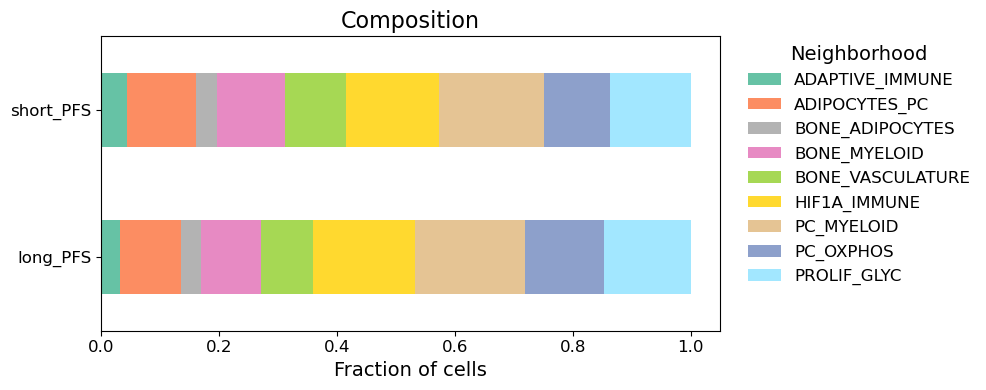

In [6]:
fig, ax = plt.subplots(figsize=(10, 4))
summary_stats.plot(kind='barh', stacked=True, color=neighborhood_color_map, ax=ax)
ax.grid(False)
ax.set_title('Composition', fontsize=16)
ax.set_xlabel('Fraction of cells', fontsize=14)
ax.set_ylabel('', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.legend(title='Neighborhood', bbox_to_anchor=(1.02, 1.02), framealpha=0, loc='upper left', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'composition_nbh_pfs.{extension}'))

In [7]:
grouped_df = pd.crosstab(
    [adata.obs['image_ID'], adata.obs['PFS_group']], 
    adata.obs['Phenotype4'],
    normalize='index'
) 
summary_stats = grouped_df.groupby(level='PFS_group').agg(['mean'])
summary_stats.columns = summary_stats.columns.get_level_values(0)
summary_stats

Phenotype4,Adipocytes,CD4 T,CD8 T,DCs,Endothelial,HLA-DR+ Macs/monos,HSPCs,MPO+,Macs/monos,Neutrophils,OB/RUNX2+,Osteoclasts,Osteocytes,PCs,Unknown
PFS_group,,,,,,,,,,,,,,,
long_PFS,0.014844,0.027775,0.045136,0.009173,0.025965,0.043899,0.017099,0.056993,0.036566,0.217720,0.006473,0.001127,0.005320,0.344677,0.147234
short_PFS,0.016494,0.037339,0.047877,0.009225,0.028829,0.051016,0.020195,0.067229,0.038654,0.205398,0.005867,0.001374,0.005944,0.341178,0.123382


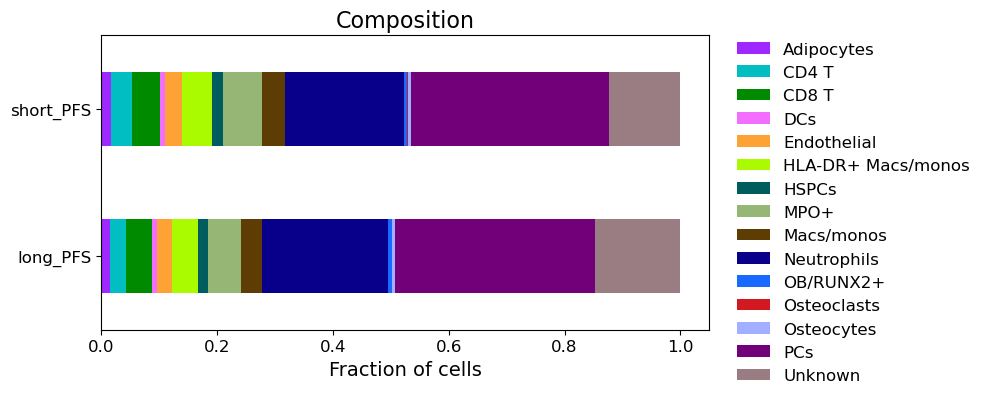

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))
summary_stats.plot(kind='barh', stacked=True, color=phenotype_color_map, ax=ax)
ax.grid(False)
ax.set_title('Composition', fontsize=16)
ax.set_xlabel('Fraction of cells', fontsize=14)
ax.set_ylabel('', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.legend(title='', bbox_to_anchor=(1.02, 1.03), framealpha=0, loc='upper left', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'composition_phenotype_pfs.{extension}'))

# Lets check the correlation of immune scores

In [9]:
image_score = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/downstream/clinical_correlation/immune_COZI_normalized_scores_images.csv')
image_score.drop(columns=['Unnamed: 0'], inplace=True)
image_score

,image_ID,Adipocytes_Adipocytes,Adipocytes_CD4+Tcells,Adipocytes_CD8+Tcells,Adipocytes_Dendritic Cells,Adipocytes_Endothelial cells,Adipocytes_HSCs,Adipocytes_MPO+,Adipocytes_Macrophages/Monocytes,Adipocytes_Neutrophils,...,activated Macrophages/Monocytes_Neutrophils,activated Macrophages/Monocytes_Osteoblast lineage,activated Macrophages/Monocytes_Osteoclasts,activated Macrophages/Monocytes_Osteocyte,activated Macrophages/Monocytes_Plasma Cells/MM cells,activated Macrophages/Monocytes_Unknown,activated Macrophages/Monocytes_activated Macrophages/Monocytes,disease2,PFS_group,patient_ID
0,TS-373_IMC77_B_001.csv,0.054949,-0.042442,-0.000054,NaN,0.006039,-0.026232,0.014985,0.060071,-0.051738,...,-0.026314,-0.008306,-0.012124,-0.117433,0.114973,-0.032708,0.063877,MM_BD,long_PFS,IMC77
1,TS-373_IMC12_UB_001.csv,0.017522,-0.000978,0.027636,0.022704,0.036517,-0.005331,0.021044,0.122594,0.025438,...,0.019077,-0.003451,-0.015048,-0.054673,0.010244,0.020360,0.072932,MM_noBD,short_PFS,IMC12
2,TS-373_IMC86_B_002.csv,0.074396,-0.012884,0.010356,-0.004471,0.047025,0.010169,0.030255,0.015164,-0.006827,...,-0.051165,-0.002485,NaN,NaN,0.023202,0.066702,0.233631,MM_BD,long_PFS,IMC86
3,TS-373_IMC42_B_001.csv,0.006835,-0.000281,0.040975,-0.003852,0.076014,-0.011231,0.050192,0.002582,-0.001653,...,0.023325,-0.004305,NaN,-0.512502,0.137482,0.093784,0.196278,MM_BD,short_PFS,IMC42
4,TS-373_IMC35_B_002.csv,0.052895,0.010146,0.007824,0.002515,0.016190,0.014287,0.022086,0.061283,-0.029895,...,-0.007205,0.144214,-0.011655,-0.131931,0.072948,0.065150,0.010436,MM_BD,long_PFS,IMC35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,TS-373_IMC66_B_002.csv,0.039755,-0.006857,0.014388,0.001476,0.051430,0.013311,-0.018550,0.009587,0.022176,...,0.066775,0.010641,0.211530,-0.038138,-0.091069,0.021801,0.106203,MM_BD,long_PFS,IMC66
126,TS-373_IMC87-1_UB_001.csv,0.151764,-0.002687,-0.002672,0.003690,0.021375,-0.003574,0.004219,-0.005765,0.007472,...,0.080432,0.031366,NaN,NaN,0.002039,0.084110,0.156326,MM_noBD,long_PFS,IMC87-1
127,TS-373_IMC53_B_002.csv,0.177587,0.017003,0.049589,-0.003030,0.077515,-0.021291,0.011758,-0.003055,0.022034,...,0.053857,-0.004224,-0.007753,-0.000644,-0.026546,0.048306,0.049889,MM_BD,short_PFS,IMC53
128,TS-373_IMC47_B_002.csv,0.058939,-0.006602,-0.001844,0.002252,0.041461,-0.005442,0.013603,-0.042782,0.005282,...,0.044577,0.109517,0.003230,-0.004668,0.054135,0.090577,0.092481,MM_BD,short_PFS,IMC47


In [10]:
roi_mapping = adata.obs[['ROI', 'image_ID']].drop_duplicates()
roi_mapping.set_index('image_ID', inplace=True)
image_score = image_score.merge(roi_mapping, left_on='image_ID', right_index=True)
image_score = image_score[image_score['ROI'].isin(['001', '002'])]
# image_score = image_score[['Plasma Cells/MM cells_CD4+Tcells', 'CD4+Tcells_Plasma Cells/MM cells', 'Plasma Cells/MM cells_CD8+Tcells', 'CD8+Tcells_Plasma Cells/MM cells',
#                            'Plasma Cells/MM cells_Dendritic Cells', 'Dendritic Cells_Plasma Cells/MM cells', 'Plasma Cells/MM cells_Neutrophils', 'Neutrophils_Plasma Cells/MM cells',
#                            'image_ID', 'disease2', 'PFS_group', 'patient_ID', 'ROI']]
image_score

,image_ID,Adipocytes_Adipocytes,Adipocytes_CD4+Tcells,Adipocytes_CD8+Tcells,Adipocytes_Dendritic Cells,Adipocytes_Endothelial cells,Adipocytes_HSCs,Adipocytes_MPO+,Adipocytes_Macrophages/Monocytes,Adipocytes_Neutrophils,...,activated Macrophages/Monocytes_Osteoblast lineage,activated Macrophages/Monocytes_Osteoclasts,activated Macrophages/Monocytes_Osteocyte,activated Macrophages/Monocytes_Plasma Cells/MM cells,activated Macrophages/Monocytes_Unknown,activated Macrophages/Monocytes_activated Macrophages/Monocytes,disease2,PFS_group,patient_ID,ROI
0,TS-373_IMC77_B_001.csv,0.054949,-0.042442,-0.000054,NaN,0.006039,-0.026232,0.014985,0.060071,-0.051738,...,-0.008306,-0.012124,-0.117433,0.114973,-0.032708,0.063877,MM_BD,long_PFS,IMC77,001
1,TS-373_IMC12_UB_001.csv,0.017522,-0.000978,0.027636,0.022704,0.036517,-0.005331,0.021044,0.122594,0.025438,...,-0.003451,-0.015048,-0.054673,0.010244,0.020360,0.072932,MM_noBD,short_PFS,IMC12,001
2,TS-373_IMC86_B_002.csv,0.074396,-0.012884,0.010356,-0.004471,0.047025,0.010169,0.030255,0.015164,-0.006827,...,-0.002485,NaN,NaN,0.023202,0.066702,0.233631,MM_BD,long_PFS,IMC86,002
3,TS-373_IMC42_B_001.csv,0.006835,-0.000281,0.040975,-0.003852,0.076014,-0.011231,0.050192,0.002582,-0.001653,...,-0.004305,NaN,-0.512502,0.137482,0.093784,0.196278,MM_BD,short_PFS,IMC42,001
4,TS-373_IMC35_B_002.csv,0.052895,0.010146,0.007824,0.002515,0.016190,0.014287,0.022086,0.061283,-0.029895,...,0.144214,-0.011655,-0.131931,0.072948,0.065150,0.010436,MM_BD,long_PFS,IMC35,002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,TS-373_IMC66_B_002.csv,0.039755,-0.006857,0.014388,0.001476,0.051430,0.013311,-0.018550,0.009587,0.022176,...,0.010641,0.211530,-0.038138,-0.091069,0.021801,0.106203,MM_BD,long_PFS,IMC66,002
126,TS-373_IMC87-1_UB_001.csv,0.151764,-0.002687,-0.002672,0.003690,0.021375,-0.003574,0.004219,-0.005765,0.007472,...,0.031366,NaN,NaN,0.002039,0.084110,0.156326,MM_noBD,long_PFS,IMC87-1,001
127,TS-373_IMC53_B_002.csv,0.177587,0.017003,0.049589,-0.003030,0.077515,-0.021291,0.011758,-0.003055,0.022034,...,-0.004224,-0.007753,-0.000644,-0.026546,0.048306,0.049889,MM_BD,short_PFS,IMC53,002
128,TS-373_IMC47_B_002.csv,0.058939,-0.006602,-0.001844,0.002252,0.041461,-0.005442,0.013603,-0.042782,0.005282,...,0.109517,0.003230,-0.004668,0.054135,0.090577,0.092481,MM_BD,short_PFS,IMC47,002


In [11]:
interaction_cols = list(image_score.columns[1:-4])
paired_scores = image_score.pivot(index='patient_ID', columns='ROI', values=interaction_cols)
paired_scores

Adipocytes_Adipocytes           Adipocytes_CD4+Tcells            \
ROI                          001       002                   001       002   
patient_ID                                                                   
IMC01                   0.007012  0.020830              0.002668 -0.010642   
IMC07                   0.100087  0.056572              0.025228  0.000478   
IMC08                   0.015625  0.166994             -0.012990 -0.011893   
IMC09                   0.065412  0.128214             -0.003250 -0.013748   
IMC12                   0.017522  0.038552             -0.000978  0.004389   
...                          ...       ...                   ...       ...   
IMC90.1                 0.014533  0.029653              0.000370 -0.021424   
IMC92                   0.012044  0.028131             -0.002005 -0.014885   
IMC93                   0.112073  0.139967             -0.020687  0.081564   
IMC95                   0.215368  0.026664             -0.036248 -0.003061   
IMC96                   0.169583  0.035188              0.023445 -0.006846   

           Adipocytes_CD8+Tcells           Adipocytes_Dendritic Cells  \
ROI                          001       002                        001   
patient_ID                                                              
IMC01                  -0.008773 -0.016930                   0.006021   
IMC07                   0.012182  0.010272                  -0.006459   
IMC08                   0.035145 -0.020744                   0.007472   
IMC09                  -0.015417 -0.000907                   0.024176   
IMC12                   0.027636  0.015158                   0.022704   
...                          ...       ...                        ...   
IMC90.1                -0.006743  0.021341                   0.000479   
IMC92                  -0.013275 -0.016936                  -0.001264   
IMC93                   0.007184  0.004425                   0.000123   
IMC95                   0.003422 -0.009215                   0.024418   
IMC96                   0.004139 -0.009591                  -0.000171   

                     Adipocytes_Endothelial cells            ...  \
ROI              002                          001       002  ...   
patient_ID                                                   ...   
IMC01       0.006136                     0.024582  0.057176  ...   
IMC07      -0.002492                     0.028656  0.059998  ...   
IMC08       0.036070                     0.044836  0.114421  ...   
IMC09      -0.007375                     0.067368  0.051283  ...   
IMC12       0.065911                     0.036517  0.015765  ...   
...              ...                          ...       ...  ...   
IMC90.1    -0.007505                    -0.012261  0.002338  ...   
IMC92      -0.024619                    -0.009545  0.009195  ...   
IMC93       0.022483                     0.041390  0.039642  ...   
IMC95      -0.002278                     0.032257  0.012846  ...   
IMC96      -0.000576                     0.026328  0.000031  ...   

           activated Macrophages/Monocytes_Osteoclasts            \
ROI                                                001       002   
patient_ID                                                         
IMC01                                              NaN       NaN   
IMC07                                        -0.005813 -0.006305   
IMC08                                         0.010287 -0.009423   
IMC09                                              NaN       NaN   
IMC12                                        -0.015048  0.015776   
...                                                ...       ...   
IMC90.1                                      -0.006889  0.030030   
IMC92                                              NaN       NaN   
IMC93                                        -0.014973 -0.016165   
IMC95                                              NaN       NaN   
IMC96                                              NaN  0.

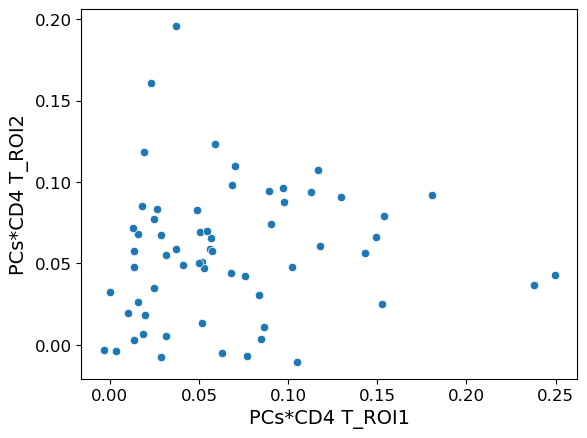

In [12]:
sns.scatterplot(data=paired_scores, x=('Plasma Cells/MM cells_CD4+Tcells', '001'), y=('Plasma Cells/MM cells_CD4+Tcells', '002'))
plt.xlabel(xlabel = 'PCs*CD4 T_ROI1',fontsize=14)
plt.ylabel(ylabel = 'PCs*CD4 T_ROI2',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(os.path.join(save_path_supp, f'interaction_ROI1_2_CD4+_Tcells.{extension}'), bbox_inches='tight')

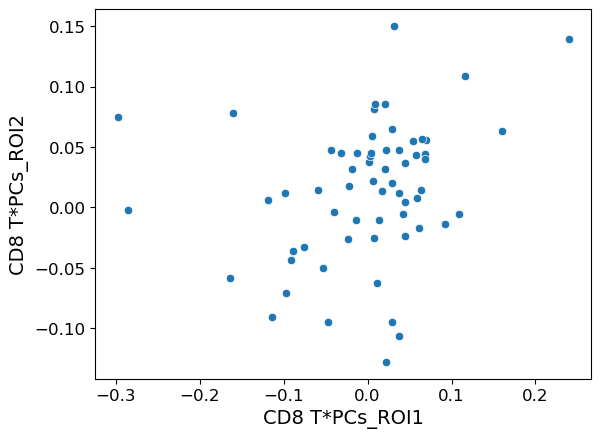

In [13]:
sns.scatterplot(data=paired_scores, x=('CD8+Tcells_Plasma Cells/MM cells', '001'), y=('CD8+Tcells_Plasma Cells/MM cells', '002'))
plt.xlabel(xlabel = 'CD8 T*PCs_ROI1',fontsize=14)
plt.ylabel(ylabel = 'CD8 T*PCs_ROI2',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(os.path.join(save_path_supp, f'interaction_ROI1_2_CD8+_Tcells.{extension}'), bbox_inches='tight')

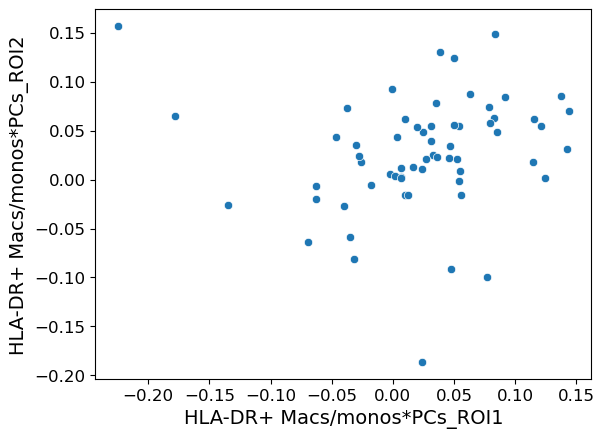

In [14]:
sns.scatterplot(data=paired_scores, x=('activated Macrophages/Monocytes_Plasma Cells/MM cells', '001'), y=('activated Macrophages/Monocytes_Plasma Cells/MM cells', '002'))
plt.xlabel(xlabel = 'HLA-DR+ Macs/monos*PCs_ROI1',fontsize=14)
plt.ylabel(ylabel = 'HLA-DR+ Macs/monos*PCs_ROI2',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(os.path.join(save_path_supp, f'interaction_ROI1_2_Macs.{extension}'), bbox_inches='tight')

# Inspect neighborhood scores, nbh enrichment and immune interaction scores

In [15]:
nbh_enrichment2

,Unnamed: 0,CD8+Tcells_Plasma Cells/MM cells,Plasma Cells/MM cells_CD8+Tcells,Plasma Cells/MM cells_CD4+Tcells,CD4+Tcells_Plasma Cells/MM cells,Dendritic Cells_Plasma Cells/MM cells,Plasma Cells/MM cells_Dendritic Cells,Plasma Cells/MM cells_Neutrophils,Neutrophils_Plasma Cells/MM cells,Plasma Cells/MM cells_activated Macrophages/Monocytes,activated Macrophages/Monocytes_Plasma Cells/MM cells,Macrophages/Monocytes_Plasma Cells/MM cells,Plasma Cells/MM cells_Macrophages/Monocytes,Plasma Cells/MM cells_Plasma Cells/MM cells,CD8+Tcells_CD8+Tcells,CD4+Tcells_CD4+Tcells,disease2,PFS_group,image_ID
patient_ID,,,,,,,,,,,,,,,,,,,
IMC96,64,0.046797,0.032261,0.021196,0.045480,0.017284,0.032502,-0.065145,0.060430,0.074335,0.086724,0.040017,0.038834,0.200427,0.034707,0.023271,MM_BD,short_PFS,TS-373_IMC96_B_002.csv
IMC80,52,0.056144,0.039077,0.092027,0.068972,-0.013893,0.014597,-0.013934,0.018573,0.026290,0.001366,0.003186,0.087034,0.633672,0.186952,0.126816,MM_BD,short_PFS,TS-373_IMC80_B_002.csv
IMC39,22,0.024712,0.114794,0.096596,0.002412,-0.008496,0.049609,0.082290,-0.098473,0.097773,0.014645,-0.101163,0.164387,0.625689,0.129525,0.165278,MM_BD,short_PFS,TS-373_IMC39_B_001.csv
IMC40-1,23,0.054816,0.046151,0.044310,0.002827,0.000591,0.005503,0.008874,-0.090463,0.090187,0.084224,-0.043700,0.125454,0.959302,0.100813,0.052599,MM_BD,short_PFS,TS-373_IMC40-1_B_002.csv
IMC42,24,0.112301,0.072559,0.048011,0.040698,0.039458,0.070137,-0.026196,0.098983,0.055790,0.111319,0.081391,0.080990,0.436158,0.267961,0.129268,MM_BD,short_PFS,TS-373_IMC42_B_001.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IMC95,63,0.024765,0.018946,-0.000059,0.010935,-0.006587,-0.007637,-0.069350,0.116830,0.039383,0.004185,0.054757,0.088954,0.093215,-0.007629,0.021616,MM_BD,long_PFS,TS-373_IMC95_B_002.csv
IMC52,32,-0.067450,0.092729,0.051675,-0.050408,-0.011168,0.050266,0.200882,-0.317160,0.057335,-0.001859,-0.094298,0.106377,0.841959,0.116500,0.012274,MM_BD,long_PFS,TS-373_IMC52_B_001.csv
IMC60-1,39,0.015475,0.034365,0.057524,0.016633,0.025426,0.087609,0.041392,0.083930,0.040217,0.034125,0.049736,0.107645,0.189248,0.065967,0.090423,MM_BD,long_PFS,TS-373_IMC60-1_B_002.csv


In [16]:
nbh_enrichment2.rename(columns={'CD8+Tcells_Plasma Cells/MM cells': 'CD8 T*PCs', 'Plasma Cells/MM cells_CD8+Tcells': 'PCs*CD8 T','Plasma Cells/MM cells_CD4+Tcells': 'PCs*CD4 T',
                                'CD4+Tcells_Plasma Cells/MM cells': 'CD4 T*PCs', 'Plasma Cells/MM cells_Dendritic Cells': 'PCs*DCs', 'Dendritic Cells_Plasma Cells/MM cells': 'DCs*PCs',
                                'Plasma Cells/MM cells_Neutrophils': 'PCs*Neutrophils', 'Neutrophils_Plasma Cells/MM cells': 'Neutrophils*PCs',
                                'Plasma Cells/MM cells_activated Macrophages/Monocytes': 'PCs*HLA-DR+ Macs/monos', 'activated Macrophages/Monocytes_Plasma Cells/MM cells': 'HLA-DR+ Macs/monos*PCs',
                                'Plasma Cells/MM cells_Macrophages/Monocytes': 'PCs*Macs/monos', 'Macrophages/Monocytes_Plasma Cells/MM cells': 'Macs/monos*PCs',
                                'Plasma Cells/MM cells_Plasma Cells/MM cells': 'PCs*PCs'}, inplace=True)

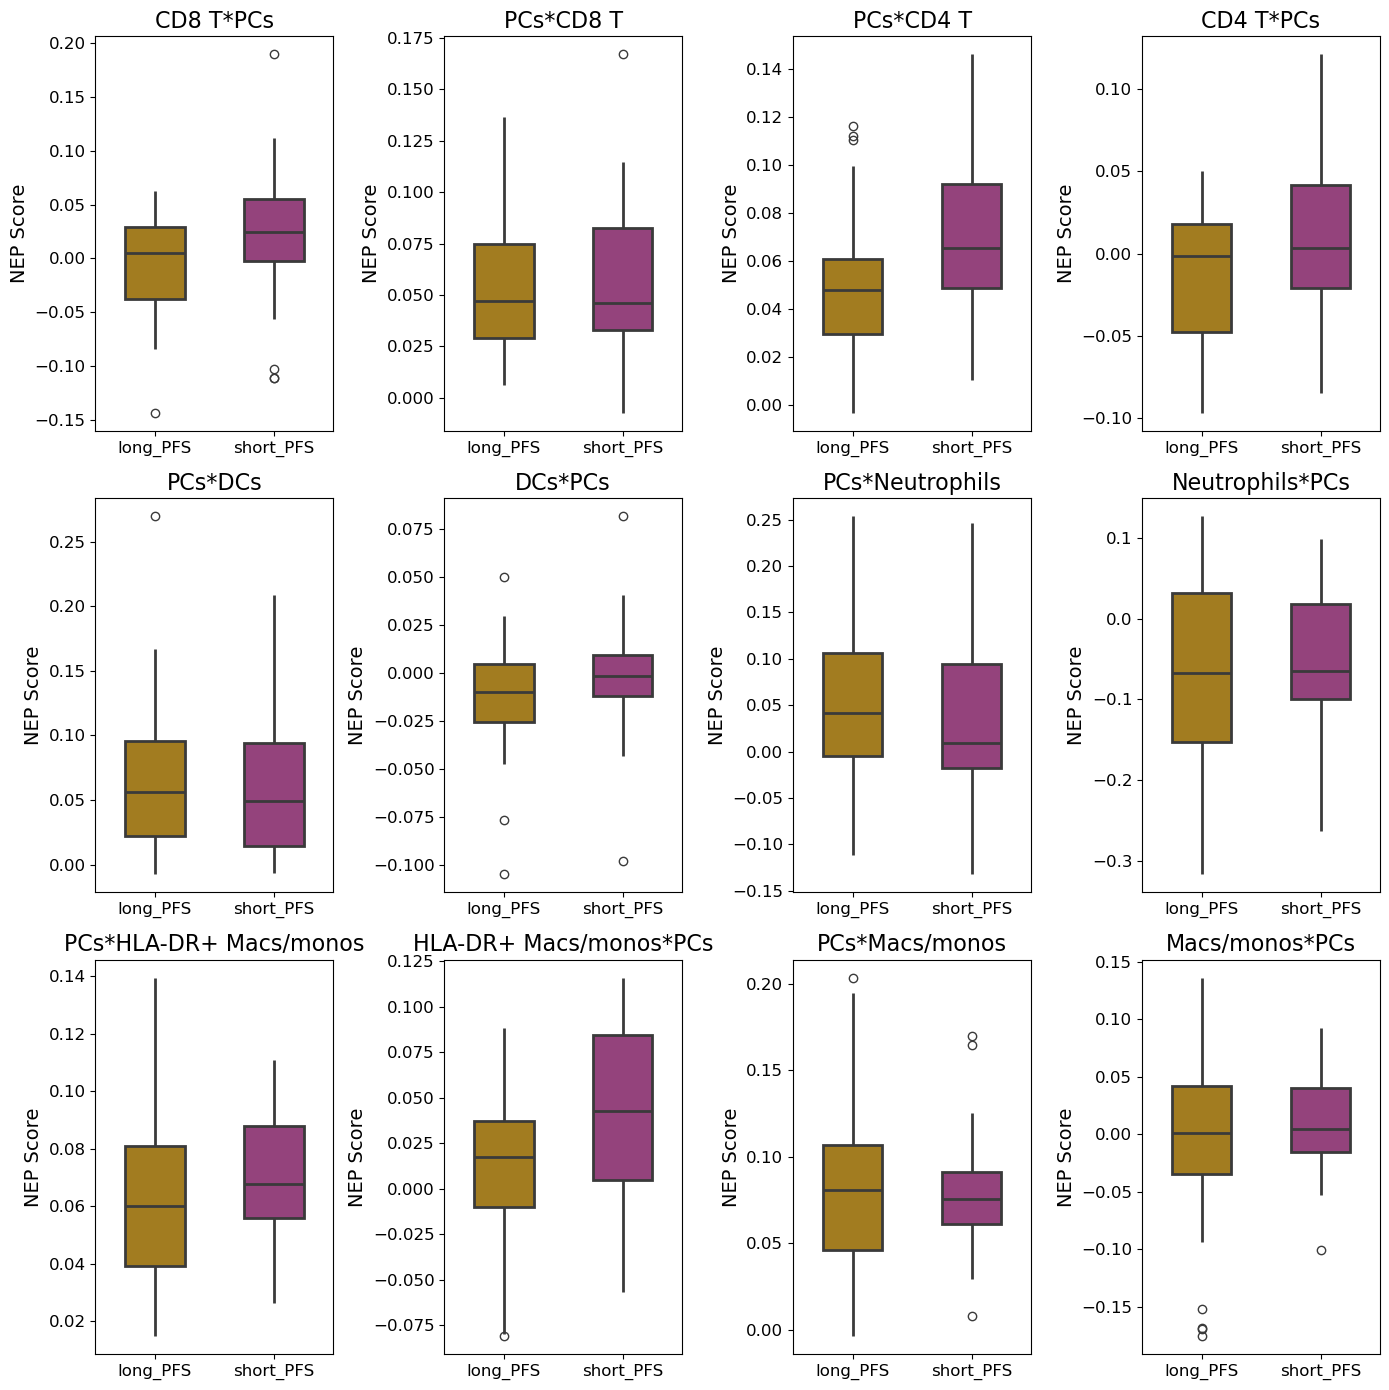

In [17]:
fig, ax = plt.subplots(3, 4, figsize=(14, 14))
order = ['long_PFS', 'short_PFS']
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='CD8 T*PCs', palette=pfs_color_map, ax=ax[0,0], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='PCs*CD8 T', palette=pfs_color_map, ax=ax[0,1], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='PCs*CD4 T', palette=pfs_color_map, ax=ax[0,2], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='CD4 T*PCs', palette=pfs_color_map, ax=ax[0,3], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='PCs*DCs', palette=pfs_color_map, ax=ax[1,0], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='DCs*PCs', palette=pfs_color_map, ax=ax[1,1], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='PCs*Neutrophils', palette=pfs_color_map, ax=ax[1,2], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='Neutrophils*PCs', palette=pfs_color_map, ax=ax[1,3], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='PCs*HLA-DR+ Macs/monos', palette=pfs_color_map, ax=ax[2,0], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='HLA-DR+ Macs/monos*PCs', palette=pfs_color_map, ax=ax[2,1], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='PCs*Macs/monos', palette=pfs_color_map, ax=ax[2,2], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment2, x='PFS_group', y='Macs/monos*PCs', palette=pfs_color_map, ax=ax[2,3], order=order, showcaps=False, linewidth=2, width=0.5)
for axi in ax.flatten():
    axi.set_xlabel('')
    #titles = axi.get_ylabel().split('*')
    axi.set_title(axi.get_ylabel(), fontsize=16)
    axi.set_ylabel('NEP Score', fontsize=14)
    axi.set_xticklabels(axi.get_xticklabels(), fontsize=12)
    axi.set_yticklabels(axi.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'interaction_scores_per_patient.{extension}'), dpi=300)

In [18]:
long = nbh_enrichment2[(nbh_enrichment2['PFS_group'] == 'long_PFS')]['PCs*CD4 T']
short = nbh_enrichment2[(nbh_enrichment2['PFS_group'] == 'short_PFS')]['PCs*CD4 T']
stats, p = mannwhitneyu(long, short)
print(f'Mann-Whitney U test: U={stats}, p-value={p}')

Mann-Whitney U test: U=334.0, p-value=0.019639043451104964


In [19]:
long = nbh_enrichment2[(nbh_enrichment2['PFS_group'] == 'long_PFS')]['CD8 T*PCs']
short = nbh_enrichment2[(nbh_enrichment2['PFS_group'] == 'short_PFS')]['CD8 T*PCs']
stats, p = mannwhitneyu(long, short)
print(f'Mann-Whitney U test: U={stats}, p-value={p}')

Mann-Whitney U test: U=365.0, p-value=0.055480982241710004


In [20]:
long = nbh_enrichment2[(nbh_enrichment2['PFS_group'] == 'long_PFS')]['HLA-DR+ Macs/monos*PCs']
short = nbh_enrichment2[(nbh_enrichment2['PFS_group'] == 'short_PFS')]['HLA-DR+ Macs/monos*PCs']
stats, p = mannwhitneyu(long, short)
print(f'Mann-Whitney U test: U={stats}, p-value={p}')

Mann-Whitney U test: U=323.0, p-value=0.013082134074101038


## Compare to celltype frequencies

In [21]:
df = pd.crosstab(
    index = [adata.obs['patient_ID'], adata.obs['PFS_group']],
    columns = adata.obs['Phenotype4'],
    normalize='index'
)
df = df.reset_index()
df

Phenotype4,patient_ID,PFS_group,Adipocytes,CD4 T,CD8 T,DCs,Endothelial,HLA-DR+ Macs/monos,HSPCs,MPO+,Macs/monos,Neutrophils,OB/RUNX2+,Osteoclasts,Osteocytes,PCs,Unknown
0,IMC01,long_PFS,0.010058,0.020000,0.034566,0.023699,0.024162,0.079191,0.027399,0.099653,0.047514,0.240809,0.003121,0.000000,0.019306,0.181850,0.188671
1,IMC07,long_PFS,0.011046,0.009093,0.067336,0.000279,0.015565,0.018075,0.004184,0.010879,0.015509,0.032803,0.000781,0.000279,0.001785,0.748340,0.064045
2,IMC08,long_PFS,0.013640,0.028676,0.031468,0.006122,0.018043,0.029750,0.010955,0.042208,0.036301,0.104178,0.004296,0.000644,0.013640,0.563527,0.096552
3,IMC09,long_PFS,0.013915,0.043304,0.065401,0.000390,0.008794,0.022710,0.003340,0.071357,0.096237,0.351442,0.000557,0.000000,0.001113,0.068518,0.252922
4,IMC12,short_PFS,0.010697,0.029338,0.034468,0.009759,0.041098,0.029463,0.023896,0.137057,0.013762,0.244777,0.005192,0.000438,0.005255,0.320593,0.094207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,IMC90.1,long_PFS,0.005761,0.053484,0.038069,0.020086,0.005839,0.059790,0.012456,0.041105,0.017750,0.291164,0.004671,0.000467,0.003036,0.332114,0.114208
59,IMC92,long_PFS,0.016371,0.025529,0.026560,0.005953,0.016829,0.078077,0.017287,0.080710,0.037665,0.412364,0.005953,0.000000,0.000458,0.169777,0.106468
60,IMC93,long_PFS,0.024680,0.020350,0.058192,0.003464,0.037409,0.025026,0.037842,0.052650,0.057932,0.198563,0.008486,0.001472,0.007534,0.300831,0.165570
61,IMC95,long_PFS,0.011165,0.001285,0.002651,0.000241,0.003936,0.021124,0.006104,0.141687,0.038554,0.552369,0.000723,0.000000,0.001124,0.021205,0.197831


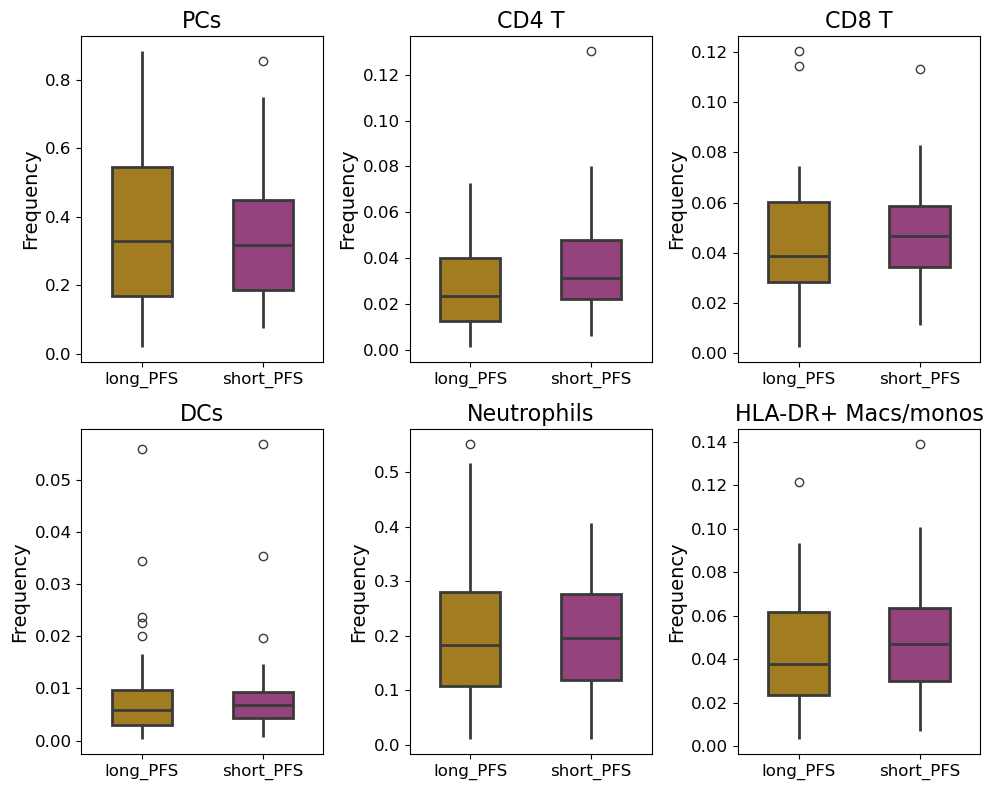

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(10, 8))
order = ['long_PFS', 'short_PFS']
sns.boxplot(data=df, x='PFS_group', y='PCs', palette=pfs_color_map, ax=ax[0,0], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=df, x='PFS_group', y='CD4 T', palette=pfs_color_map, ax=ax[0,1], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=df, x='PFS_group', y='CD8 T', palette=pfs_color_map, ax=ax[0,2], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=df, x='PFS_group', y='DCs', palette=pfs_color_map, ax=ax[1,0], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=df, x='PFS_group', y='Neutrophils', palette=pfs_color_map, ax=ax[1,1], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=df, x='PFS_group', y='HLA-DR+ Macs/monos', palette=pfs_color_map, ax=ax[1,2], order=order, showcaps=False, linewidth=2, width=0.5)
for axi in ax.flatten():
    axi.set_xlabel('')
    axi.set_title(axi.get_ylabel(), fontsize=16)
    axi.set_ylabel('Frequency', fontsize=14)
    axi.set_xticklabels(axi.get_xticklabels(), fontsize=12)
    axi.set_yticklabels(axi.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(save_path_supp, f'cellfreq_per_patient.{extension}'), dpi=300)


In [23]:
long = df[(df['PFS_group'] == 'long_PFS')]['CD4 T']
short = df[(df['PFS_group'] == 'short_PFS')]['CD4 T']
stats, p = mannwhitneyu(long, short)
print(f'Mann-Whitney U test: U={stats}, p-value={p}')

Mann-Whitney U test: U=375.0, p-value=0.10516415358158356


In [24]:
long = df[(df['PFS_group'] == 'long_PFS')]['HLA-DR+ Macs/monos']
short = df[(df['PFS_group'] == 'short_PFS')]['HLA-DR+ Macs/monos']
stats, p = mannwhitneyu(long, short)
print(f'Mann-Whitney U test: U={stats}, p-value={p}')

Mann-Whitney U test: U=424.0, p-value=0.34485778522945243


# Nhood_enrichments and neighborhood abundances

## Abundance

In [25]:
grouped_df = pd.crosstab(
    [adata.obs['image_ID'], adata.obs['PFS_group']], 
    adata.obs['cellcharter_CN'],
    normalize='index'
)
grouped_df = grouped_df.reset_index()
grouped_df

cellcharter_CN,image_ID,PFS_group,ADAPTIVE_IMMUNE,ADIPOCYTES_PC,BONE_ADIPOCYTES,BONE_MYELOID,BONE_VASCULATURE,HIF1A_IMMUNE,PC_MYELOID,PC_OXPHOS,PROLIF_GLYC
0,TS-373_IMC01_UB_001.csv,long_PFS,0.006377,0.057629,0.048418,0.102976,0.238073,0.166037,0.199575,0.022437,0.158479
1,TS-373_IMC01_UB_002.csv,long_PFS,0.103487,0.103714,0.097600,0.089674,0.131567,0.114583,0.205616,0.060915,0.092844
2,TS-373_IMC07_UB_001.csv,long_PFS,0.015228,0.139919,0.020825,0.042171,0.035793,0.075491,0.370298,0.158792,0.141481
3,TS-373_IMC07_UB_002.csv,long_PFS,0.013376,0.119313,0.007909,0.048233,0.010935,0.120680,0.410174,0.140695,0.128686
4,TS-373_IMC08_UB_001.csv,long_PFS,0.024222,0.084667,0.055556,0.048222,0.245556,0.090667,0.231111,0.135333,0.084667
...,...,...,...,...,...,...,...,...,...,...,...
121,TS-373_IMC93_B_002.csv,long_PFS,0.013409,0.118337,0.031847,0.098894,0.029501,0.144653,0.224103,0.113476,0.225779
122,TS-373_IMC95_B_001.csv,long_PFS,0.005626,0.070882,0.074707,0.147840,0.093159,0.202970,0.205221,0.053780,0.145815
123,TS-373_IMC95_B_002.csv,long_PFS,0.004746,0.065076,0.012241,0.132775,0.039720,0.213215,0.352486,0.043093,0.136648
124,TS-373_IMC96_B_001.csv,short_PFS,0.008671,0.076069,0.026358,0.117457,0.116185,0.222775,0.251214,0.034682,0.146590


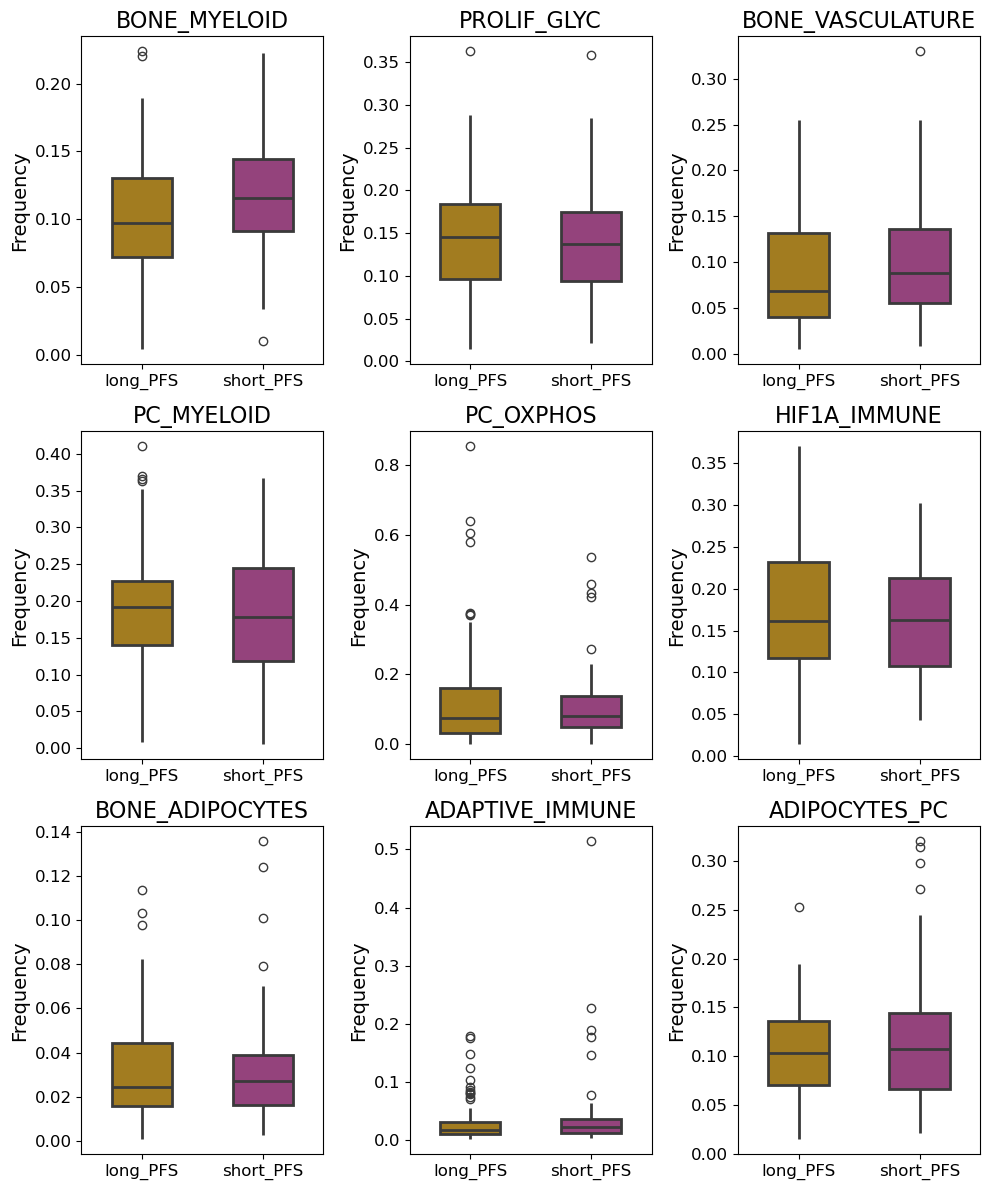

In [26]:
fig, ax = plt.subplots(3,3, figsize=(10, 12))
sns.boxplot(data=grouped_df, x='PFS_group', y='BONE_MYELOID', palette=pfs_color_map, ax=ax[0,0], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=grouped_df, x='PFS_group', y='PROLIF_GLYC', palette=pfs_color_map, ax=ax[0,1], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=grouped_df, x='PFS_group', y='BONE_VASCULATURE', palette=pfs_color_map, ax=ax[0,2], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=grouped_df, x='PFS_group', y='PC_MYELOID', palette=pfs_color_map, ax=ax[1,0], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=grouped_df, x='PFS_group', y='PC_OXPHOS', palette=pfs_color_map, ax=ax[1,1], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=grouped_df, x='PFS_group', y='HIF1A_IMMUNE', palette=pfs_color_map, ax=ax[1,2], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=grouped_df, x='PFS_group', y='BONE_ADIPOCYTES', palette=pfs_color_map, ax=ax[2,0], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=grouped_df, x='PFS_group', y='ADAPTIVE_IMMUNE', palette=pfs_color_map, ax=ax[2,1], order=order, showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=grouped_df, x='PFS_group', y='ADIPOCYTES_PC', palette=pfs_color_map, ax=ax[2,2], order=order, showcaps=False, linewidth=2, width=0.5)
for axi in ax.flatten():
    axi.set_xlabel('')
    axi.set_title(axi.get_ylabel(), fontsize=16)
    axi.set_ylabel('Frequency', fontsize=14)
    axi.set_xticklabels(axi.get_xticklabels(), fontsize=12)
    axi.set_yticklabels(axi.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(save_path_supp, f'nhood_proportions_per_image.{extension}'), dpi=300)

In [27]:
long = grouped_df[(grouped_df['PFS_group'] == 'long_PFS')]['BONE_MYELOID']
short = grouped_df[(grouped_df['PFS_group'] == 'short_PFS')]['BONE_MYELOID']
stats, p = mannwhitneyu(long, short)
print(f'Mann-Whitney U test: U={stats}, p-value={p}')

Mann-Whitney U test: U=1605.0, p-value=0.07283173055364522


## Enrichments

In [28]:
nbh_enrichment.rename(columns={'adaptive_immune*bone_vasculature': 'ADAPTIVE_IMMUNE*BONE_VASCULATURE', 'adaptive_immune*focal_pc_oxphos': 'ADAPTIVE_IMMUNE*PC_OXPHOS',
                                'focal_pc_oxphos*stroma_adipocyte': 'PC_OXPHOS*ADIPOCYTES_PC', 'pc_myeloid*focal_pc_oxphos': 'PC_MYELOID*PC_OXPHOS',
                                'bone_vasculature*focal_pc_oxphos': 'BONE_VASCULATURE*PC_OXPHOS', 'hypoxic_immune*focal_pc_oxphos': 'HIF1A_IMMUNE*PC_OXPHOS'}, inplace=True)
nbh_enrichment

,ADAPTIVE_IMMUNE*BONE_VASCULATURE,ADAPTIVE_IMMUNE*PC_OXPHOS,PC_OXPHOS*ADIPOCYTES_PC,PC_MYELOID*PC_OXPHOS,BONE_VASCULATURE*PC_OXPHOS,HIF1A_IMMUNE*PC_OXPHOS,pfs
patient_ID,,,,,,,
IMC01,0.085426,0.060378,0.006710,0.057370,0.014387,0.010911,long_PFS
IMC48,-0.059406,0.002142,0.078299,0.052587,0.029000,0.002480,long_PFS
IMC49,-0.062451,0.002315,0.082981,0.099617,0.060709,-0.028822,long_PFS
IMC95,-0.022953,0.006856,-0.013860,0.054446,0.042117,0.032821,long_PFS
IMC52,0.031746,0.020038,0.253212,0.054363,-0.171192,-0.172075,long_PFS
...,...,...,...,...,...,...,...
IMC64,-0.048151,0.105023,0.033918,0.058994,-0.092002,-0.066045,short_PFS
IMC28,0.016032,-0.195926,0.024286,0.142301,-0.001092,-0.073463,short_PFS
IMC40-1,-0.027147,-0.073084,0.128330,0.050058,0.038018,-0.052480,short_PFS


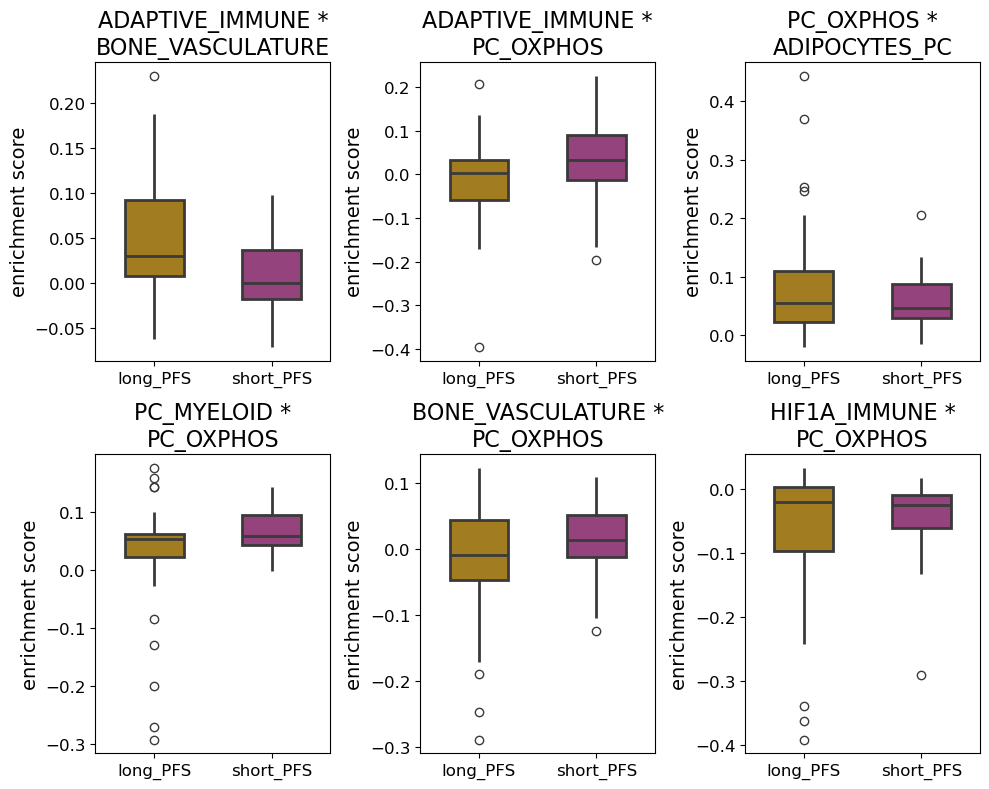

In [29]:
fig, ax = plt.subplots(2,3, figsize=(10, 8))
sns.boxplot(data=nbh_enrichment, x='pfs', y='ADAPTIVE_IMMUNE*BONE_VASCULATURE', palette=pfs_color_map, ax=ax[0,0], showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment, x='pfs', y='ADAPTIVE_IMMUNE*PC_OXPHOS', palette=pfs_color_map, ax=ax[0,1], showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment, x='pfs', y='PC_OXPHOS*ADIPOCYTES_PC', palette=pfs_color_map, ax=ax[0,2], showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment, x='pfs', y='PC_MYELOID*PC_OXPHOS', palette=pfs_color_map, ax=ax[1,0], showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment, x='pfs', y='BONE_VASCULATURE*PC_OXPHOS', palette=pfs_color_map, ax=ax[1,1], showcaps=False, linewidth=2, width=0.5)
sns.boxplot(data=nbh_enrichment, x='pfs', y='HIF1A_IMMUNE*PC_OXPHOS', palette=pfs_color_map, ax=ax[1,2], showcaps=False, linewidth=2, width=0.5)
for axi in ax.flatten():
    axi.set_xlabel('')
    titles = axi.get_ylabel().split('*')
    axi.set_title(f'{titles[0]} *\n{titles[1]}', fontsize=16)
    axi.set_ylabel('enrichment score', fontsize=14)
    axi.set_xticklabels(axi.get_xticklabels(), fontsize=12)
    axi.set_yticklabels(axi.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'nhood_enrichment_per_patient.{extension}'), dpi=300)

In [30]:
long = nbh_enrichment[nbh_enrichment['pfs'] == 'long_PFS']['ADAPTIVE_IMMUNE*BONE_VASCULATURE']
short = nbh_enrichment[nbh_enrichment['pfs'] == 'short_PFS']['ADAPTIVE_IMMUNE*BONE_VASCULATURE']
stats, p = mannwhitneyu(long, short)
print(f'Mann-Whitney U test: U={stats}, p-value={p}')

Mann-Whitney U test: U=682.0, p-value=0.018942530970950763


In [31]:
long = nbh_enrichment[nbh_enrichment['pfs'] == 'long_PFS']['PC_MYELOID*PC_OXPHOS']
short = nbh_enrichment[nbh_enrichment['pfs'] == 'short_PFS']['PC_MYELOID*PC_OXPHOS']
stats, p = mannwhitneyu(long, short)
print(f'Mann-Whitney U test: U={stats}, p-value={p}')

Mann-Whitney U test: U=377.0, p-value=0.07955880723023918


In [32]:
long = nbh_enrichment[nbh_enrichment['pfs'] == 'long_PFS']['ADAPTIVE_IMMUNE*PC_OXPHOS']
short = nbh_enrichment[nbh_enrichment['pfs'] == 'short_PFS']['ADAPTIVE_IMMUNE*PC_OXPHOS']
stats, p = mannwhitneyu(long, short)
print(f'Mann-Whitney U test: U={stats}, p-value={p}')

Mann-Whitney U test: U=342.0, p-value=0.02606237739206203


# Kaplan Meier

In [33]:
md = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/metadata/metadata.csv')
md = md[md['Cohort'].isin(['B', 'UB'])]
md = md.dropna(subset=['Days to progression (PFS)']).reset_index(drop=True)
md['PCs*CD4 T'] = md['IMC label'].map(nbh_enrichment2['PCs*CD4 T'])
md['CD8 T*PCs'] = md['IMC label'].map(nbh_enrichment2['CD8 T*PCs'])
md['HLA-DR+ Macs/monos*PCs'] = md['IMC label'].map(nbh_enrichment2['HLA-DR+ Macs/monos*PCs'])
md['ADAPTIVE_IMMUNE*BONE_VASCULATURE'] = md['IMC label'].map(nbh_enrichment['ADAPTIVE_IMMUNE*BONE_VASCULATURE'])
md['ADAPTIVE_IMMUNE*PC_OXPHOS'] = md['IMC label'].map(nbh_enrichment['ADAPTIVE_IMMUNE*PC_OXPHOS'])
md['PC_MYELOID*PC_OXPHOS'] = md['IMC label'].map(nbh_enrichment['PC_MYELOID*PC_OXPHOS'])
md['ADAPTIVE_IMMUNE*PC_OXPHOS'] = md['IMC label'].map(nbh_enrichment['ADAPTIVE_IMMUNE*PC_OXPHOS'])

In [34]:
kmf = KaplanMeierFitter()
E = md['Event (Progress) occurred']
T = md['Days to progression (PFS)']
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 63 total observations, 11 right-censored observations>

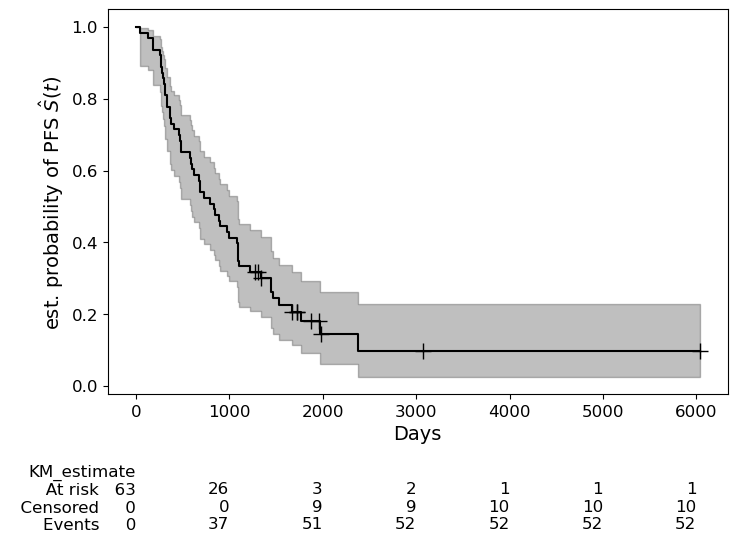

In [35]:
fig, ax = plt.subplots(figsize=(8, 5))
kmf.plot_survival_function(show_censors=True, ax=ax, color='black', legend=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
add_at_risk_counts(kmf)
ax.set_ylabel(r"est. probability of PFS $\hat{S}(t)$", fontsize=14)
ax.set_xlabel('Days', fontsize=14)
plt.xticks(fontsize=12)
plt.savefig(os.path.join(save_path_supp, f'PFS_curve_all.{extension}'))

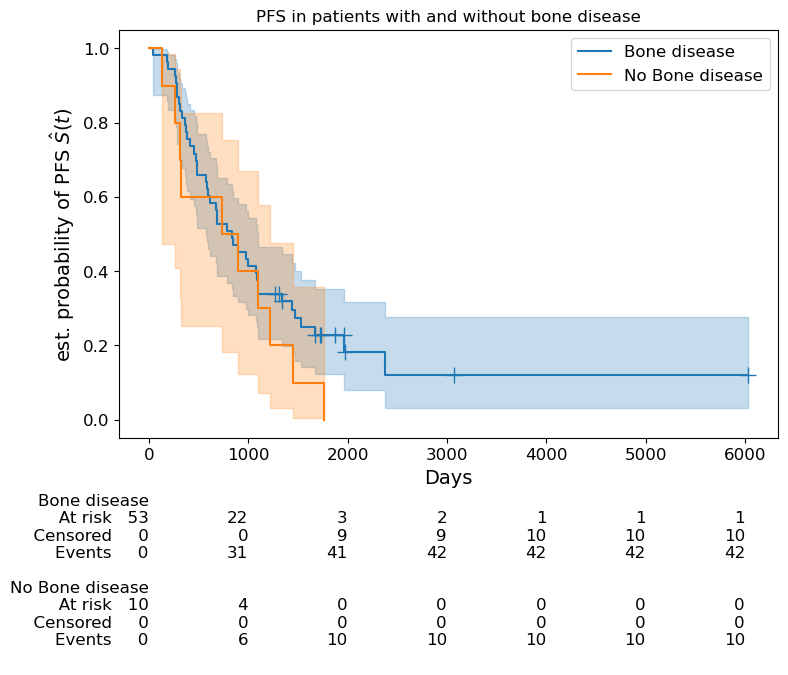

In [36]:
fig, ax = plt.subplots(figsize=(8, 7))
cohort = (md['Cohort'] == 'B')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
kmf_frac = KaplanMeierFitter()
kmf_frac.fit(T[cohort], event_observed=E[cohort], label='Bone disease')
ax = kmf_frac.plot_survival_function(ax=ax, show_censors=True)

kmf_nofrac = KaplanMeierFitter()
kmf_nofrac.fit(T[~cohort], event_observed=E[~cohort], label='No Bone disease')
ax = kmf_nofrac.plot_survival_function(ax=ax, show_censors=True)
ax.set_ylabel(r"est. probability of PFS $\hat{S}(t)$", fontsize=14)
ax.set_xlabel('Days', fontsize=14)
ax.legend(fontsize=12)
plt.title('PFS in patients with and without bone disease')
add_at_risk_counts(kmf_frac, kmf_nofrac, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.tight_layout()
plt.savefig(os.path.join(save_path_supp, f'PFS_curve_bone_disease.{extension}'))

## PC_CD4

In [37]:
nbh_enrichment2.groupby('PFS_group')['PCs*CD4 T'].describe()

,count,mean,std,min,25%,50%,75%,max
PFS_group,,,,,,,,
long_PFS,35.0,0.051211,0.032329,-0.003157,0.029842,0.047854,0.060935,0.116461
short_PFS,29.0,0.072314,0.035179,0.010560,0.048823,0.065592,0.092027,0.146197


In [38]:
nbh_enrichment2['PCs*CD4 T'].describe()

count    64.000000
mean      0.060773
std       0.035017
min      -0.003157
25%       0.040487
50%       0.053279
75%       0.089313
max       0.146197
Name: PCs*CD4 T, dtype: float64

In [39]:
md['PCs*CD4 T_score'] = np.where(md['PCs*CD4 T'] > 0.06, 'high', 'low')

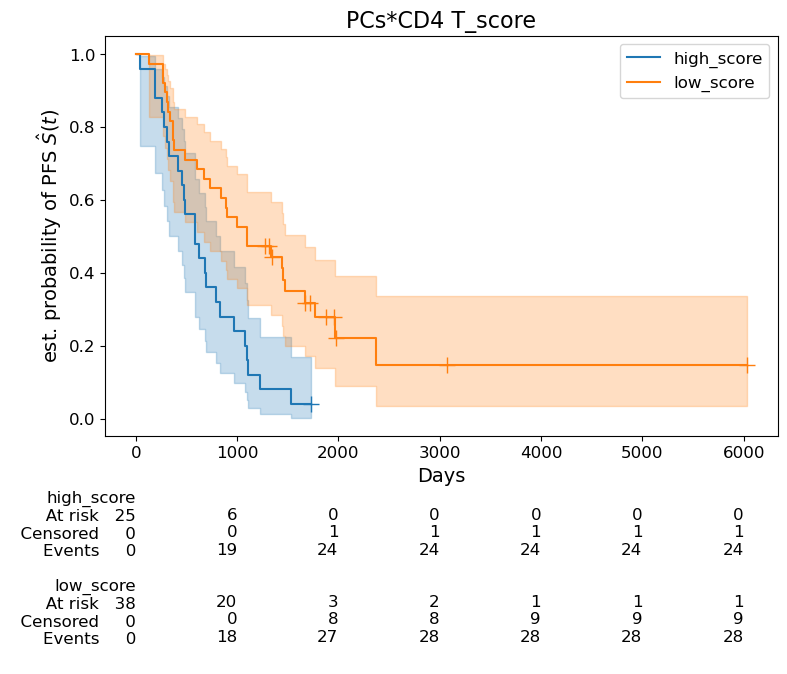

In [40]:
interaction_name = 'PCs*CD4 T_score'
E = md['Event (Progress) occurred']
T = md['Days to progression (PFS)']
fig, ax = plt.subplots(figsize=(8, 7))
high_int = (md[interaction_name] == 'high')
kmf_high_int = KaplanMeierFitter()
kmf_high_int.fit(T[high_int], event_observed=E[high_int], label='high_score')
ax = kmf_high_int.plot_survival_function(ax=ax, show_censors=True)
kmf_low_int = KaplanMeierFitter()
kmf_low_int.fit(T[~high_int], event_observed=E[~high_int], label='low_score')
ax = kmf_low_int.plot_survival_function(ax=ax, show_censors=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel(r"est. probability of PFS $\hat{S}(t)$", fontsize=14)
ax.set_xlabel('Days', fontsize=14)
ax.legend(fontsize=12)
plt.title(f'{interaction_name}', fontsize=16)
add_at_risk_counts(kmf_high_int, kmf_low_int, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.tight_layout()
plt.savefig(os.path.join(save_path, f"Kaplan_meier_{interaction_name}.{extension}"))

In [41]:
results = logrank_test(T[high_int], T[~high_int], E[high_int], E[~high_int], alpha=.95)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           9.75 <0.005      9.12

## PC/D8

In [42]:
nbh_enrichment2.groupby('PFS_group')['CD8 T*PCs'].describe()

,count,mean,std,min,25%,50%,75%,max
PFS_group,,,,,,,,
long_PFS,35.0,-0.005067,0.047628,-0.143404,-0.037717,0.005030,0.029429,0.062647
short_PFS,29.0,0.021541,0.066515,-0.111440,-0.002001,0.024712,0.054816,0.189722


In [43]:
nbh_enrichment2['CD8 T*PCs'].describe()

count    64.000000
mean      0.006990
std       0.058041
min      -0.143404
25%      -0.027245
50%       0.017391
75%       0.042788
max       0.189722
Name: CD8 T*PCs, dtype: float64

In [44]:
md['CD8 T*PCs_score'] = np.where(md['CD8 T*PCs'] > 0.05, 'high', 'low')

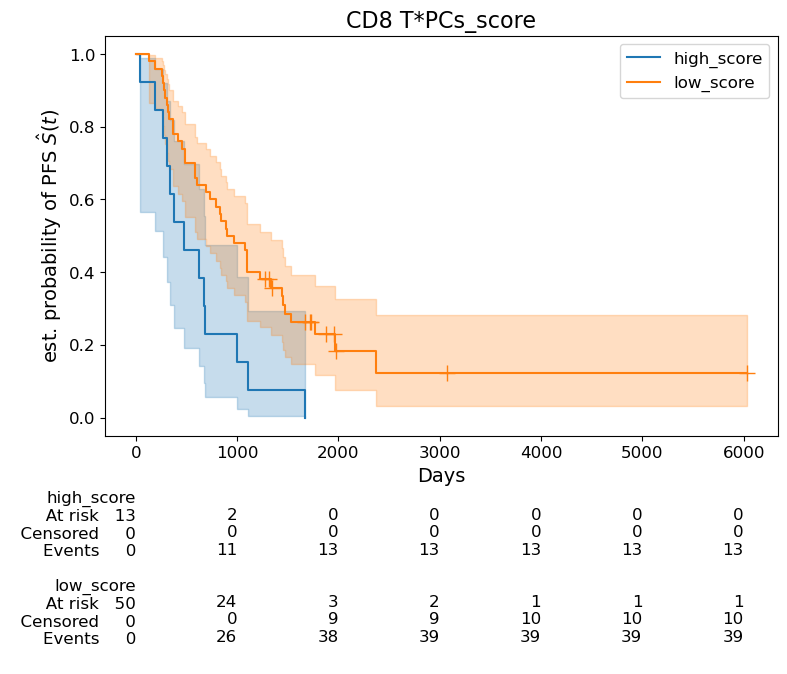

In [45]:
interaction_name = 'CD8 T*PCs_score'
E = md['Event (Progress) occurred']
T = md['Days to progression (PFS)']
fig, ax = plt.subplots(figsize=(8, 7))
high_int = (md[interaction_name] == 'high')
kmf_high_int = KaplanMeierFitter()
kmf_high_int.fit(T[high_int], event_observed=E[high_int], label='high_score')
ax = kmf_high_int.plot_survival_function(ax=ax, show_censors=True)
kmf_low_int = KaplanMeierFitter()
kmf_low_int.fit(T[~high_int], event_observed=E[~high_int], label='low_score')
ax = kmf_low_int.plot_survival_function(ax=ax, show_censors=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel(r"est. probability of PFS $\hat{S}(t)$", fontsize=14)
ax.set_xlabel('Days', fontsize=14)
ax.legend(fontsize=12)
plt.title(f'{interaction_name}', fontsize=16)
add_at_risk_counts(kmf_high_int, kmf_low_int, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.tight_layout()
plt.savefig(os.path.join(save_path, f"Kaplan_meier_{interaction_name}.{extension}"))

In [46]:
results = logrank_test(T[high_int], T[~high_int], E[high_int], E[~high_int], alpha=.95)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           7.68 0.01      7.49

## pc macrops

In [47]:
nbh_enrichment2.groupby('PFS_group')['HLA-DR+ Macs/monos*PCs'].describe()

,count,mean,std,min,25%,50%,75%,max
PFS_group,,,,,,,,
long_PFS,35.0,0.012042,0.043011,-0.081134,-0.010164,0.017528,0.036955,0.088372
short_PFS,29.0,0.040803,0.049507,-0.056880,0.004747,0.042770,0.084224,0.116003


In [48]:
nbh_enrichment2['HLA-DR+ Macs/monos*PCs'].describe()

count    64.000000
mean      0.025074
std       0.047916
min      -0.081134
25%      -0.002109
50%       0.027676
75%       0.063685
max       0.116003
Name: HLA-DR+ Macs/monos*PCs, dtype: float64

In [49]:
md['HLA-DR+ Macs/monos*PCs_score'] = np.where(md['HLA-DR+ Macs/monos*PCs'] > 0.04, 'high', 'low')

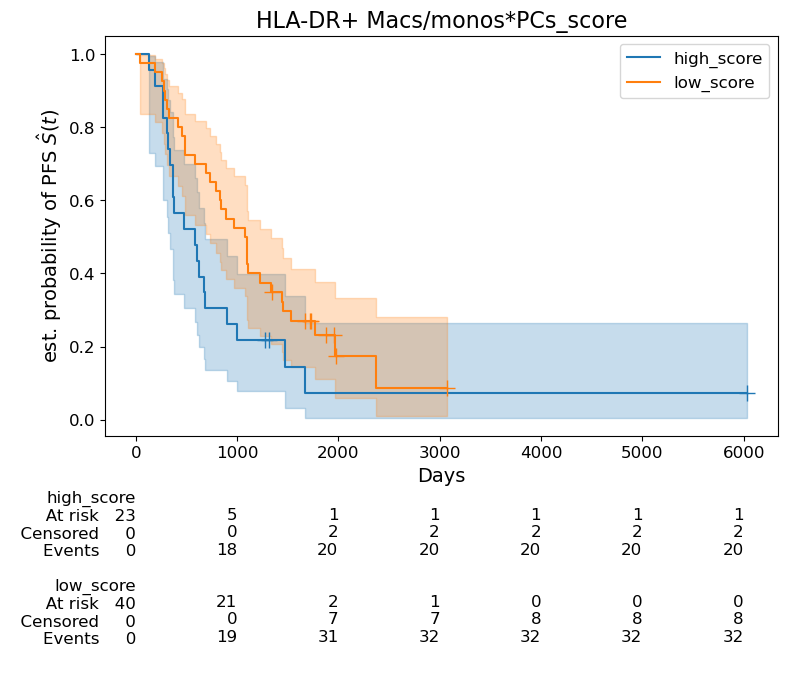

In [50]:
interaction_name = 'HLA-DR+ Macs/monos*PCs_score'
E = md['Event (Progress) occurred']
T = md['Days to progression (PFS)']
fig, ax = plt.subplots(figsize=(8, 7))
high_int = (md[interaction_name] == 'high')
kmf_high_int = KaplanMeierFitter()
kmf_high_int.fit(T[high_int], event_observed=E[high_int], label='high_score')
ax = kmf_high_int.plot_survival_function(ax=ax, show_censors=True)
kmf_low_int = KaplanMeierFitter()
kmf_low_int.fit(T[~high_int], event_observed=E[~high_int], label='low_score')
ax = kmf_low_int.plot_survival_function(ax=ax, show_censors=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel(r"est. probability of PFS $\hat{S}(t)$", fontsize=14)
ax.set_xlabel('Days', fontsize=14)
ax.legend(fontsize=12)
plt.title(f'{interaction_name}', fontsize=16)
add_at_risk_counts(kmf_high_int, kmf_low_int, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.tight_layout()
plt.savefig(os.path.join(save_path, f"Kaplan_meier_HLA-DR+ Macs_monos*PCs_score.{extension}"))

In [51]:
results = logrank_test(T[high_int], T[~high_int], E[high_int], E[~high_int], alpha=.95)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.72 0.05      4.22

## 'pc_myeloid*focal_pc_oxphos'

In [52]:
nbh_enrichment.groupby('pfs')['PC_MYELOID*PC_OXPHOS'].describe()

,count,mean,std,min,25%,50%,75%,max
pfs,,,,,,,,
long_PFS,35.0,0.024745,0.104878,-0.291816,0.022640,0.053916,0.061969,0.175398
short_PFS,29.0,0.066879,0.036549,-0.002428,0.043553,0.059150,0.094452,0.142301


In [53]:
nbh_enrichment['PC_MYELOID*PC_OXPHOS'].describe()

count    64.000000
mean      0.043837
std       0.083527
min      -0.291816
25%       0.027465
50%       0.054405
75%       0.084166
max       0.175398
Name: PC_MYELOID*PC_OXPHOS, dtype: float64

In [54]:
md['PC_MYELOID*PC_OXPHOS_score'] = np.where(md['PC_MYELOID*PC_OXPHOS'] > 0.068, 'high', 'low')

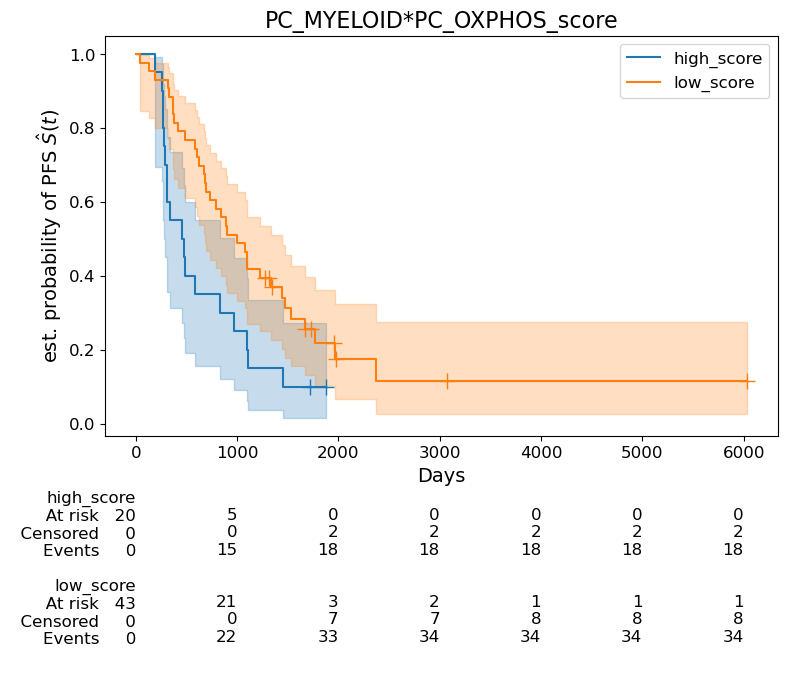

In [55]:
interaction_name = 'PC_MYELOID*PC_OXPHOS_score'
E = md['Event (Progress) occurred']
T = md['Days to progression (PFS)']
fig, ax = plt.subplots(figsize=(8, 7))
high_int = (md[interaction_name] == 'high')
kmf_high_int = KaplanMeierFitter()
kmf_high_int.fit(T[high_int], event_observed=E[high_int], label='high_score')
ax = kmf_high_int.plot_survival_function(ax=ax, show_censors=True)
kmf_low_int = KaplanMeierFitter()
kmf_low_int.fit(T[~high_int], event_observed=E[~high_int], label='low_score')
ax = kmf_low_int.plot_survival_function(ax=ax, show_censors=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel(r"est. probability of PFS $\hat{S}(t)$", fontsize=14)
ax.set_xlabel('Days', fontsize=14)
ax.legend(fontsize=12)
plt.title(f'{interaction_name}', fontsize=16)
add_at_risk_counts(kmf_high_int, kmf_low_int, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.tight_layout()
plt.savefig(os.path.join(save_path, f"Kaplan_meier_{interaction_name}.{extension}"))

In [56]:
results = logrank_test(T[high_int], T[~high_int], E[high_int], E[~high_int], alpha=.95)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.69 0.02      5.87

## 'adaptive_immune*bone_vasculature'

In [57]:
md['ADAPTIVE_IMMUNE*BONE_VASCULATURE_score'] = np.where(md['ADAPTIVE_IMMUNE*BONE_VASCULATURE'] > 0.002, 'high', 'low')

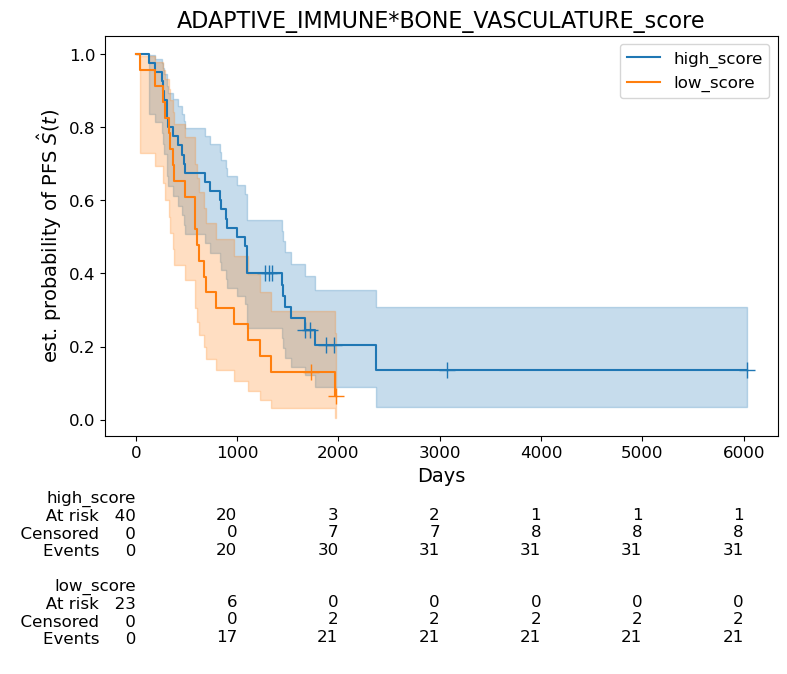

In [58]:
interaction_name = 'ADAPTIVE_IMMUNE*BONE_VASCULATURE_score'
E = md['Event (Progress) occurred']
T = md['Days to progression (PFS)']
fig, ax = plt.subplots(figsize=(8, 7))
high_int = (md[interaction_name] == 'high')
kmf_high_int = KaplanMeierFitter()
kmf_high_int.fit(T[high_int], event_observed=E[high_int], label='high_score')
ax = kmf_high_int.plot_survival_function(ax=ax, show_censors=True)
kmf_low_int = KaplanMeierFitter()
kmf_low_int.fit(T[~high_int], event_observed=E[~high_int], label='low_score')
ax = kmf_low_int.plot_survival_function(ax=ax, show_censors=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel(r"est. probability of PFS $\hat{S}(t)$", fontsize=14)
ax.set_xlabel('Days', fontsize=14)
ax.legend(fontsize=12)
plt.title(f'{interaction_name}', fontsize=16)
add_at_risk_counts(kmf_high_int, kmf_low_int, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.tight_layout()
plt.savefig(os.path.join(save_path, f"Kaplan_meier_{interaction_name}.{extension}"))

In [59]:
results = logrank_test(T[high_int], T[~high_int], E[high_int], E[~high_int], alpha=.95)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.33 0.07      3.88

## adaptive_immune*pc_oxphos

In [60]:
nbh_enrichment.groupby('pfs')['ADAPTIVE_IMMUNE*PC_OXPHOS'].describe()

,count,mean,std,min,25%,50%,75%,max
pfs,,,,,,,,
long_PFS,35.0,-0.022317,0.101403,-0.395883,-0.058364,0.003015,0.033222,0.206125
short_PFS,29.0,0.033826,0.092742,-0.195926,-0.013057,0.031999,0.091052,0.226658


In [61]:
nbh_enrichment['ADAPTIVE_IMMUNE*PC_OXPHOS'].describe()

count    64.000000
mean      0.003123
std       0.100824
min      -0.395883
25%      -0.047225
50%       0.011501
75%       0.045432
max       0.226658
Name: ADAPTIVE_IMMUNE*PC_OXPHOS, dtype: float64

In [62]:
md['ADAPTIVE_IMMUNE*PC_OXPHOS_score'] = np.where(md['ADAPTIVE_IMMUNE*PC_OXPHOS'] > 0.035, 'high', 'low')

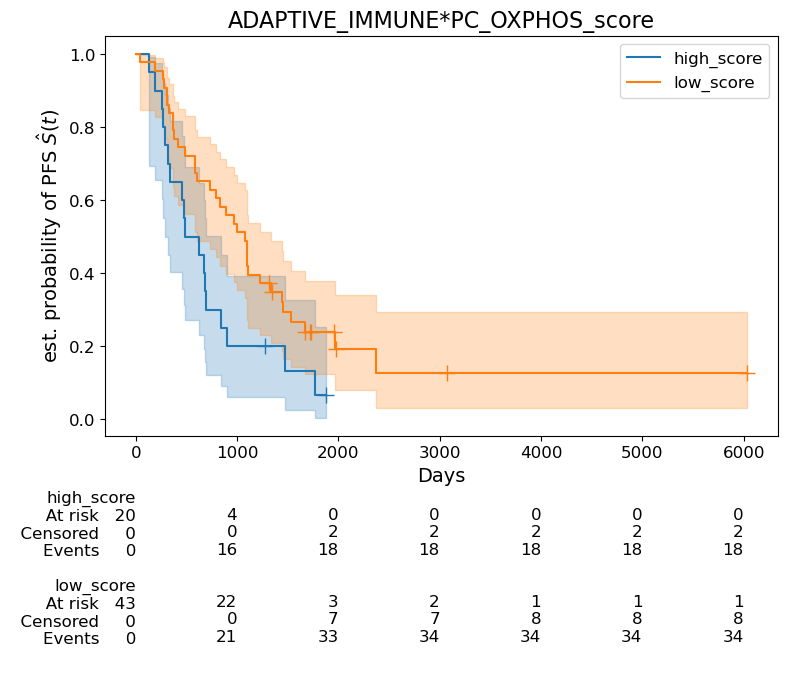

In [63]:
interaction_name = 'ADAPTIVE_IMMUNE*PC_OXPHOS_score'
E = md['Event (Progress) occurred']
T = md['Days to progression (PFS)']
fig, ax = plt.subplots(figsize=(8, 7))
high_int = (md[interaction_name] == 'high')
kmf_high_int = KaplanMeierFitter()
kmf_high_int.fit(T[high_int], event_observed=E[high_int], label='high_score')
ax = kmf_high_int.plot_survival_function(ax=ax, show_censors=True)
kmf_low_int = KaplanMeierFitter()
kmf_low_int.fit(T[~high_int], event_observed=E[~high_int], label='low_score')
ax = kmf_low_int.plot_survival_function(ax=ax, show_censors=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel(r"est. probability of PFS $\hat{S}(t)$", fontsize=14)
ax.set_xlabel('Days', fontsize=14)
ax.legend(fontsize=12)
plt.title(f'{interaction_name}', fontsize=16)
add_at_risk_counts(kmf_high_int, kmf_low_int, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.tight_layout()
plt.savefig(os.path.join(save_path, f"Kaplan_meier_{interaction_name}.{extension}"))

In [64]:
results = logrank_test(T[high_int], T[~high_int], E[high_int], E[~high_int], alpha=.95)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.49 0.03      4.87

# Combined coxph

In [65]:
md = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/metadata/metadata.csv')
md = md[md['Cohort'].isin(['B', 'UB'])]
md = md.dropna(subset=['Days to progression (PFS)']).reset_index(drop=True)
md['PC_MYELOID*PC_OXPHOS'] = md['IMC label'].map(nbh_enrichment['PC_MYELOID*PC_OXPHOS'])
md['PCs*CD4 T'] = md['IMC label'].map(nbh_enrichment2['PCs*CD4 T'])
md['CD8 T*PCs'] = md['IMC label'].map(nbh_enrichment2['CD8 T*PCs'])
md['HLA-DR+ Macs/monos*PCs'] = md['IMC label'].map(nbh_enrichment2['HLA-DR+ Macs/monos*PCs'])
md['ADAPTIVE_IMMUNE*PC_OXPHOS'] = md['IMC label'].map(nbh_enrichment['ADAPTIVE_IMMUNE*PC_OXPHOS'])
md.head()

,IMC label,Cohort,Gender,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),PFS from first time of diagnosis until relapse (days),Event (Death) occurred,OS (days),Short_long PFS (< or > 2 yrs),...,>= 1 lesion,>=3 lesions,>=5 lesions,>=10 lesions,Days to progression from noBD/SMM to BD,PC_MYELOID*PC_OXPHOS,PCs*CD4 T,CD8 T*PCs,HLA-DR+ Macs/monos*PCs,ADAPTIVE_IMMUNE*PC_OXPHOS
0,IMC01,UB,Male,67.0,True,1766.0,3424.0,True,3313.0,long_PFS,...,False,False,False,False,NaN,0.057370,0.042121,0.025990,0.036931,0.060378
1,IMC07,UB,Male,66.0,True,1448.0,1766.0,True,2891.0,long_PFS,...,False,True,False,False,1858.0,0.158636,0.018482,-0.071258,-0.002837,-0.087405
2,IMC08,B,Female,65.0,True,833.0,4050.0,True,3733.0,long_PFS,...,True,False,False,False,NaN,0.175398,0.088885,-0.022294,-0.041239,-0.059705
3,IMC09,B,Male,58.0,True,1337.0,1337.0,True,2062.0,long_PFS,...,False,False,True,False,NaN,0.019803,0.051136,0.032868,0.026402,0.016997
4,IMC12,UB,Female,79.0,True,258.0,258.0,True,1370.0,short_PFS,...,False,False,False,False,1235.0,0.104539,0.089168,0.006612,0.036144,0.050712


In [66]:
md_cox = md.drop(columns=['IMC label', 'Cohort', 'BMI', 'FISH/(translocations/del)', 'R-ISS', 'Treatment line 1', 'Days to progression from noBD/SMM to BD', 
                              'PFS from first time of diagnosis until relapse (days)', 'Short_long PFS (< or >  2 yrs)', 'Event (Death) occurred', 
                              'OS (days)', 'Fractures ossis  longi or ossis plani', '>= 1 lesion', '>=3 lesions', '>=5 lesions', '>=10 lesions', 'Bone disease later in disease course',
                              #'Gender', 'Age time of diagnosis', 
                              'Compression fractures ',
                              'Bone disease upon time of diagnosis/biopsy', 
                              ])
md_cox.head()

,Gender,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),PC_MYELOID*PC_OXPHOS,PCs*CD4 T,CD8 T*PCs,HLA-DR+ Macs/monos*PCs,ADAPTIVE_IMMUNE*PC_OXPHOS
0,Male,67.0,True,1766.0,0.057370,0.042121,0.025990,0.036931,0.060378
1,Male,66.0,True,1448.0,0.158636,0.018482,-0.071258,-0.002837,-0.087405
2,Female,65.0,True,833.0,0.175398,0.088885,-0.022294,-0.041239,-0.059705
3,Male,58.0,True,1337.0,0.019803,0.051136,0.032868,0.026402,0.016997
4,Female,79.0,True,258.0,0.104539,0.089168,0.006612,0.036144,0.050712


In [67]:
md_pfs = md_cox.dropna().reset_index(drop=True)
arr_3 = np.array(md_pfs['Days to progression (PFS)'])
arr_pfs_numeric = np.empty(len(arr_3), dtype=[('Status', '?'), ('PFS_in_days', '<f8')])
for i, e in enumerate(arr_3):
    if md_pfs['Event (Progress) occurred'][i] == False:
        arr_pfs_numeric[i] = (False, e)
    else:
        arr_pfs_numeric[i] = (True, e)
cat_cols = md_pfs.select_dtypes(include=['object']).columns
md_pfs[cat_cols] = md_pfs[cat_cols].astype('category')
md_pfs_numeric = OneHotEncoder().fit_transform(md_pfs)

In [68]:
cph = CoxPHFitter(penalizer=0.01, l1_ratio=0.5)
cph.fit(md_pfs_numeric, duration_col = 'Days to progression (PFS)', event_col = 'Event (Progress) occurred')

<lifelines.CoxPHFitter: fitted with 63 total observations, 11 right-censored observations>

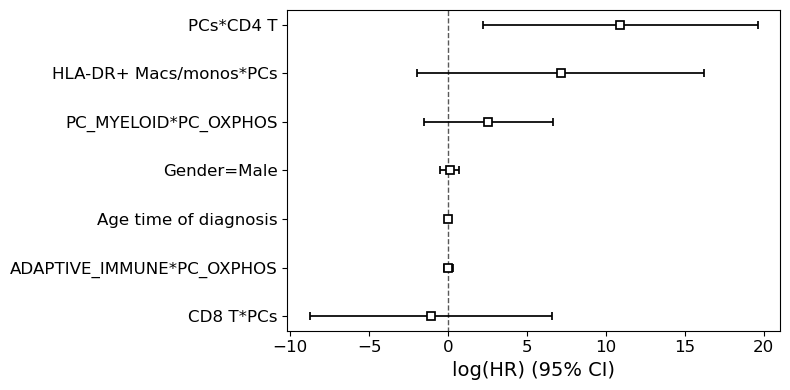

In [69]:
fig, ax = plt.subplots(figsize=(8, 4))
cph.plot(ax=ax)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_xlabel(ax.get_xlabel(), fontsize=14)
fig.tight_layout()
fig.savefig(os.path.join(save_path, f"coxph_pfs_all.{extension}"), bbox_inches='tight')

In [70]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 63 total observations, 11 right-censored observations>
             duration col = 'Days to progression (PFS)'
                event col = 'Event (Progress) occurred'
                penalizer = 0.01
                 l1 ratio = 0.5
      baseline estimation = breslow
   number of observations = 63
number of events observed = 52
   partial log-likelihood = -173.83
         time fit was run = 2025-06-11 09:03:11 UTC

---
                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                  
Gender=Male                0.10      1.11      0.31           -0.50            0.71                0.61                2.03
Age time of diagnosis      0.02      1.02      0.02           -0.02            0.05                0.98                1.05
PC_MYELOID*PC_OXPHOS       2.55     12.82      2.09           -1.54            6.65                0.21              770.06
PCs*CD4 T                 10.92  55091.48      4.44            2.22           19.62                9.18            3.31e+08
CD8 T*PCs                 -1.10      0.33      3.91           -8.76            6.56                0.00              705.15
HLA-DR+ Macs/monos*PCs     7.14   1265.17      4.65           -1.96           16.25                0.14            1.14e+07
ADAPTIVE_IMMUNE*PC_OXPHOS  0.00      1.00      0.15           -0.29            0.29                0.75                1.33

                           cmp to     z    p  -log2(p)
covariate                                             
Gender=Male                  0.00  0.33 0.74      0.43
Age time of diagnosis        0.00  0.98 0.33      1.60
PC_MYELOID*PC_OXPHOS         0.00  1.22 0.22      2.17
PCs*CD4 T                    0.00  2.46 0.01      6.17
CD8 T*PCs                    0.00 -0.28 0.78      0.36
HLA-DR+ Macs/monos*PCs       0.00  1.54 0.12      3.01
ADAPTIVE_IMMUNE*PC_OXPHOS    0.00  0.00 1.00      0.00
---
Concordance = 0.65
Partial AIC = 361.66
log-likelihood ratio test = 11.38 on 7 df
-log2(p) of ll-ratio test = 3.03


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.6460)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6666)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4812)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5160)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1738)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1862)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4437)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4356)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4281)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4369)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1514)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1569)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9779)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9785)'>]]

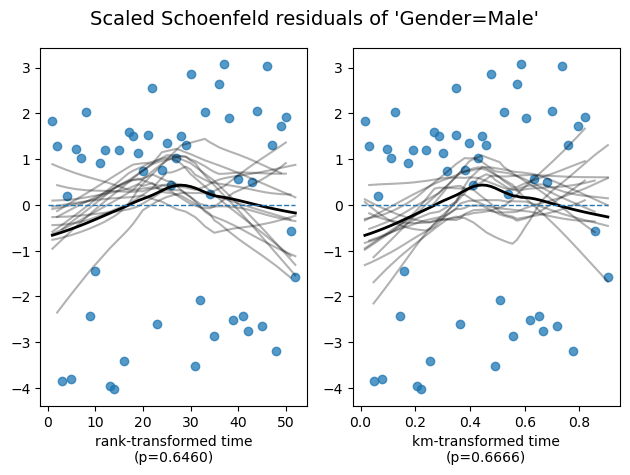

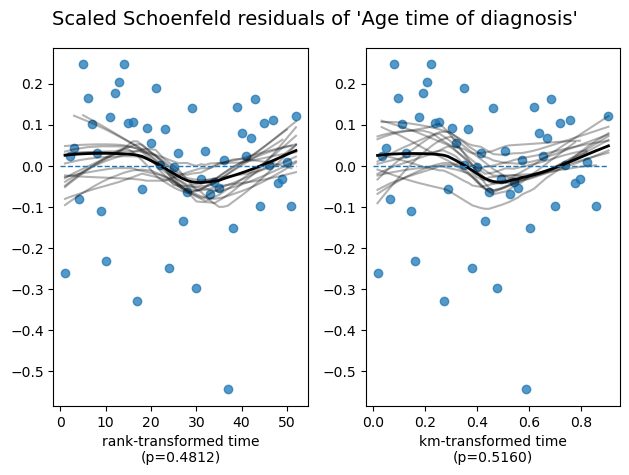

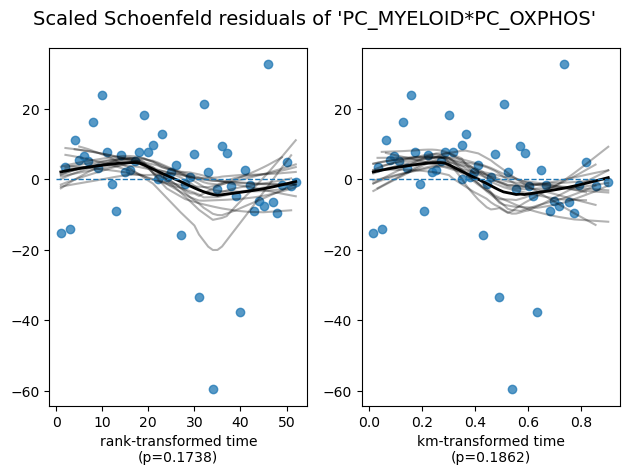

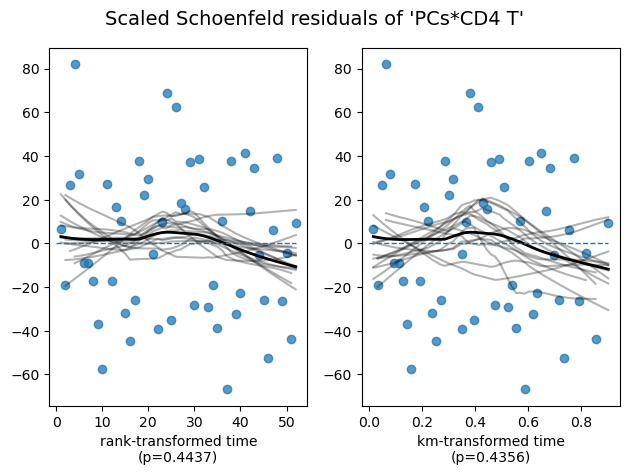

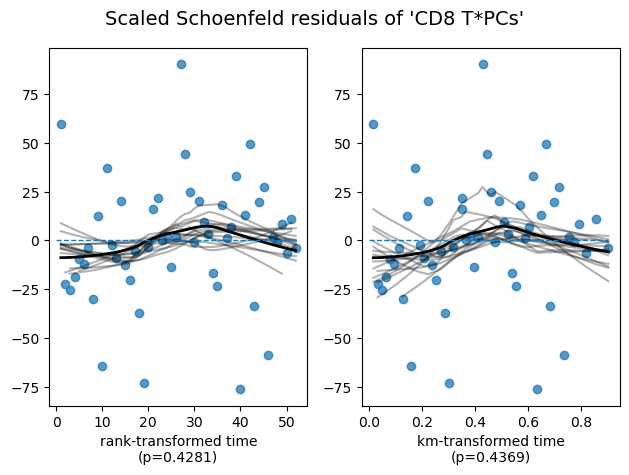

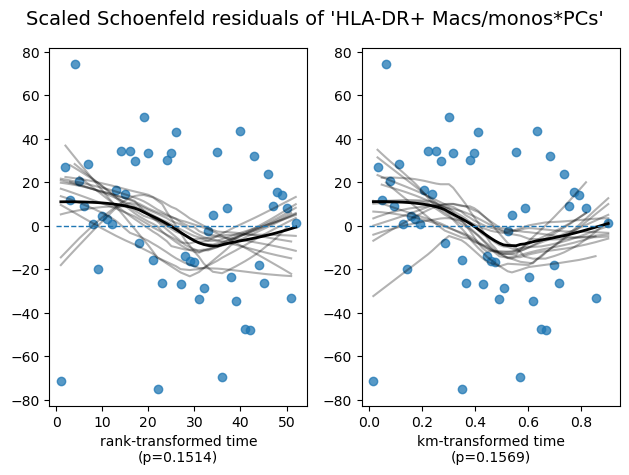

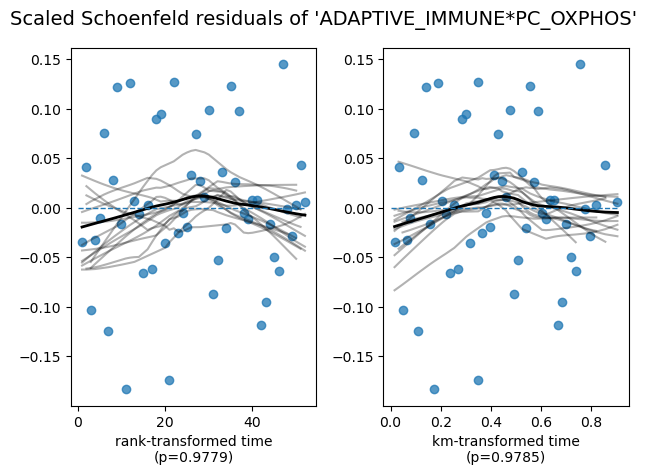

In [71]:
cph.check_assumptions(md_pfs_numeric, p_value_threshold=0.05, show_plots=True)

In [72]:
results = proportional_hazard_test(cph, md_pfs_numeric, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 63 total observations, 11 right-censored observations>
         test_name = proportional_hazard_test

---
                           test_statistic    p  -log2(p)
ADAPTIVE_IMMUNE*PC_OXPHOS            0.00 0.98      0.03
Age time of diagnosis                0.50 0.48      1.06
CD8 T*PCs                            0.63 0.43      1.22
Gender=Male                          0.21 0.65      0.63
HLA-DR+ Macs/monos*PCs               2.06 0.15      2.72
PC_MYELOID*PC_OXPHOS                 1.85 0.17      2.52
PCs*CD4 T                            0.59 0.44      1.17

In [73]:
nbh_enrichment2['PCs*CD4 T'].describe()

count    64.000000
mean      0.060773
std       0.035017
min      -0.003157
25%       0.040487
50%       0.053279
75%       0.089313
max       0.146197
Name: PCs*CD4 T, dtype: float64

In [74]:
values= list(np.arange(-0.004, 0.16, 0.05))
values = [round(v, 3) for v in values]

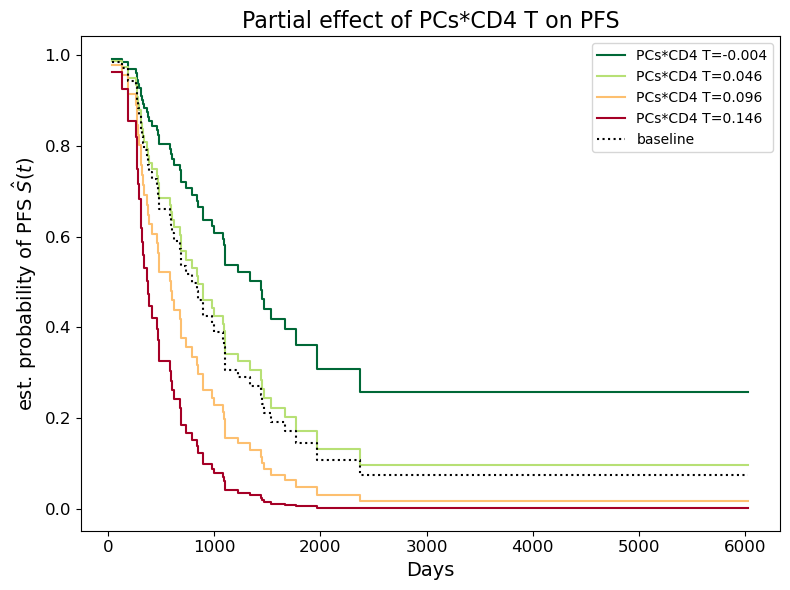

In [75]:
fig, ax = plt.subplots(figsize=(8, 6))
cph.plot_partial_effects_on_outcome('PCs*CD4 T', values= values, cmap='RdYlGn_r', ax=ax)
ax.set_title('Partial effect of PCs*CD4 T on PFS', fontsize=16)
ax.set_xlabel('Days', fontsize=14)
ax.set_ylabel(r"est. probability of PFS $\hat{S}(t)$", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(save_path, f"PCs*CD4 T_partial_effects_on_outcomes.{extension}"), bbox_inches='tight')

# Combined Coxph with scaled predictors

In [76]:
md = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/metadata/metadata.csv')
md = md[md['Cohort'].isin(['B', 'UB'])]
md = md.dropna(subset=['Days to progression (PFS)']).reset_index(drop=True)
md['PC_MYELOID*PC_OXPHOS'] = md['IMC label'].map(nbh_enrichment['PC_MYELOID*PC_OXPHOS'])*10
md['PCs*CD4 T'] = md['IMC label'].map(nbh_enrichment2['PCs*CD4 T'])*10
md['CD8 T*PCs'] = md['IMC label'].map(nbh_enrichment2['CD8 T*PCs'])*10
md['HLA-DR+ Macs/monos*PCs'] = md['IMC label'].map(nbh_enrichment2['HLA-DR+ Macs/monos*PCs'])*10
md['ADAPTIVE_IMMUNE*PC_OXPHOS'] = md['IMC label'].map(nbh_enrichment['ADAPTIVE_IMMUNE*PC_OXPHOS'])*10
md.head()

,IMC label,Cohort,Gender,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),PFS from first time of diagnosis until relapse (days),Event (Death) occurred,OS (days),Short_long PFS (< or > 2 yrs),...,>= 1 lesion,>=3 lesions,>=5 lesions,>=10 lesions,Days to progression from noBD/SMM to BD,PC_MYELOID*PC_OXPHOS,PCs*CD4 T,CD8 T*PCs,HLA-DR+ Macs/monos*PCs,ADAPTIVE_IMMUNE*PC_OXPHOS
0,IMC01,UB,Male,67.0,True,1766.0,3424.0,True,3313.0,long_PFS,...,False,False,False,False,NaN,0.573700,0.421207,0.259899,0.369306,0.603781
1,IMC07,UB,Male,66.0,True,1448.0,1766.0,True,2891.0,long_PFS,...,False,True,False,False,1858.0,1.586357,0.184823,-0.712576,-0.028371,-0.874054
2,IMC08,B,Female,65.0,True,833.0,4050.0,True,3733.0,long_PFS,...,True,False,False,False,NaN,1.753984,0.888849,-0.222941,-0.412395,-0.597045
3,IMC09,B,Male,58.0,True,1337.0,1337.0,True,2062.0,long_PFS,...,False,False,True,False,NaN,0.198029,0.511363,0.328676,0.264025,0.169969
4,IMC12,UB,Female,79.0,True,258.0,258.0,True,1370.0,short_PFS,...,False,False,False,False,1235.0,1.045386,0.891683,0.066120,0.361441,0.507116


In [77]:
md_cox = md.drop(columns=['IMC label', 'Cohort', 'BMI', 'FISH/(translocations/del)', 'R-ISS', 'Treatment line 1', 'Days to progression from noBD/SMM to BD', 
                              'PFS from first time of diagnosis until relapse (days)', 'Short_long PFS (< or >  2 yrs)', 'Event (Death) occurred', 
                              'OS (days)', 'Fractures ossis  longi or ossis plani', '>= 1 lesion', '>=3 lesions', '>=5 lesions', '>=10 lesions', 'Bone disease later in disease course',
                              #'Gender', 'Age time of diagnosis', 
                              'Compression fractures ',
                              'Bone disease upon time of diagnosis/biopsy', 
                              ])
md_cox.head()

,Gender,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),PC_MYELOID*PC_OXPHOS,PCs*CD4 T,CD8 T*PCs,HLA-DR+ Macs/monos*PCs,ADAPTIVE_IMMUNE*PC_OXPHOS
0,Male,67.0,True,1766.0,0.573700,0.421207,0.259899,0.369306,0.603781
1,Male,66.0,True,1448.0,1.586357,0.184823,-0.712576,-0.028371,-0.874054
2,Female,65.0,True,833.0,1.753984,0.888849,-0.222941,-0.412395,-0.597045
3,Male,58.0,True,1337.0,0.198029,0.511363,0.328676,0.264025,0.169969
4,Female,79.0,True,258.0,1.045386,0.891683,0.066120,0.361441,0.507116


In [78]:
md_pfs = md_cox.dropna().reset_index(drop=True)
arr_3 = np.array(md_pfs['Days to progression (PFS)'])
arr_pfs_numeric = np.empty(len(arr_3), dtype=[('Status', '?'), ('PFS_in_days', '<f8')])
for i, e in enumerate(arr_3):
    if md_pfs['Event (Progress) occurred'][i] == False:
        arr_pfs_numeric[i] = (False, e)
    else:
        arr_pfs_numeric[i] = (True, e)
cat_cols = md_pfs.select_dtypes(include=['object']).columns
md_pfs[cat_cols] = md_pfs[cat_cols].astype('category')
md_pfs_numeric = OneHotEncoder().fit_transform(md_pfs)

In [79]:
cph = CoxPHFitter(penalizer=0.01, l1_ratio=0.5)
cph.fit(md_pfs_numeric, duration_col = 'Days to progression (PFS)', event_col = 'Event (Progress) occurred')

<lifelines.CoxPHFitter: fitted with 63 total observations, 11 right-censored observations>

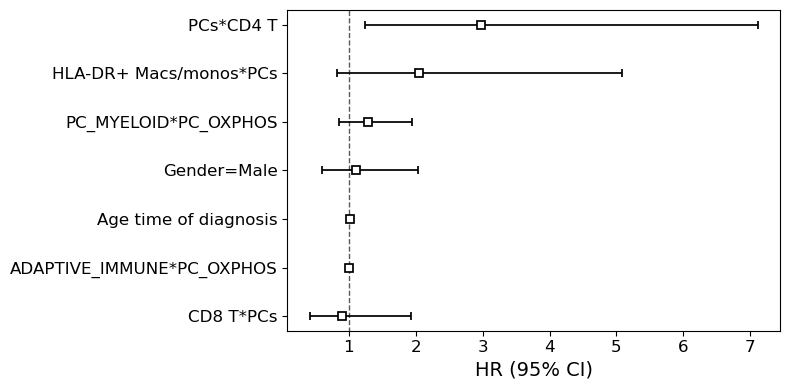

In [80]:
fig, ax = plt.subplots(figsize=(8, 4))
cph.plot(ax=ax, hazard_ratios=True)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_xlabel(ax.get_xlabel(), fontsize=14)
fig.tight_layout()
fig.savefig(os.path.join(save_path, f"coxph_pfs_all_scaled.{extension}"), bbox_inches='tight')

In [81]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 63 total observations, 11 right-censored observations>
             duration col = 'Days to progression (PFS)'
                event col = 'Event (Progress) occurred'
                penalizer = 0.01
                 l1 ratio = 0.5
      baseline estimation = breslow
   number of observations = 63
number of events observed = 52
   partial log-likelihood = -173.83
         time fit was run = 2025-06-11 09:03:13 UTC

---
                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                  
Gender=Male                0.10      1.11      0.31           -0.50            0.71                0.61                2.03
Age time of diagnosis      0.02      1.02      0.02           -0.02            0.05                0.98                1.05
PC_MYELOID*PC_OXPHOS       0.26      1.29      0.21           -0.15            0.66                0.86                1.94
PCs*CD4 T                  1.09      2.98      0.44            0.22            1.96                1.25                7.11
CD8 T*PCs                 -0.11      0.90      0.39           -0.88            0.66                0.42                1.93
HLA-DR+ Macs/monos*PCs     0.71      2.04      0.46           -0.20            1.63                0.82                5.08
ADAPTIVE_IMMUNE*PC_OXPHOS  0.00      1.00      0.01           -0.03            0.03                0.97                1.03

                           cmp to     z    p  -log2(p)
covariate                                             
Gender=Male                  0.00  0.33 0.74      0.43
Age time of diagnosis        0.00  0.98 0.33      1.60
PC_MYELOID*PC_OXPHOS         0.00  1.22 0.22      2.17
PCs*CD4 T                    0.00  2.46 0.01      6.17
CD8 T*PCs                    0.00 -0.28 0.78      0.36
HLA-DR+ Macs/monos*PCs       0.00  1.54 0.12      3.01
ADAPTIVE_IMMUNE*PC_OXPHOS    0.00  0.00 1.00      0.00
---
Concordance = 0.65
Partial AIC = 361.66
log-likelihood ratio test = 11.38 on 7 df
-log2(p) of ll-ratio test = 3.03

In [82]:
results = proportional_hazard_test(cph, md_pfs_numeric, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 63 total observations, 11 right-censored observations>
         test_name = proportional_hazard_test

---
                           test_statistic    p  -log2(p)
ADAPTIVE_IMMUNE*PC_OXPHOS            0.00 0.98      0.03
Age time of diagnosis                0.50 0.48      1.06
CD8 T*PCs                            0.63 0.43      1.22
Gender=Male                          0.21 0.65      0.63
HLA-DR+ Macs/monos*PCs               2.06 0.15      2.72
PC_MYELOID*PC_OXPHOS                 1.85 0.17      2.52
PCs*CD4 T                            0.59 0.44      1.17

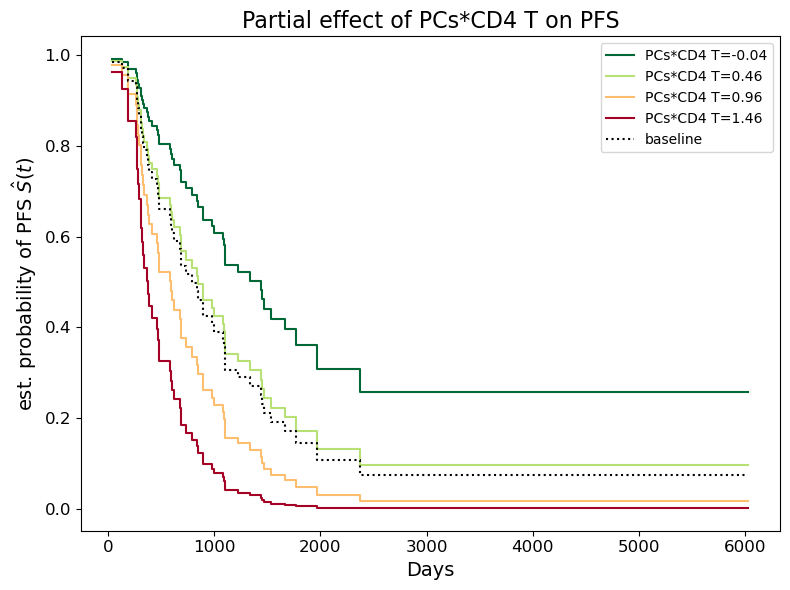

In [83]:
values= list(np.arange(-0.004, 0.16, 0.05)*10)
values = [round(v, 3) for v in values]
fig, ax = plt.subplots(figsize=(8, 6))
cph.plot_partial_effects_on_outcome('PCs*CD4 T', values= values, cmap='RdYlGn_r', ax=ax)
ax.set_title('Partial effect of PCs*CD4 T on PFS', fontsize=16)
ax.set_xlabel('Days', fontsize=14)
ax.set_ylabel(r"est. probability of PFS $\hat{S}(t)$", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(save_path, f"PCs*CD4 T_partial_effects_on_outcomes_scaled.{extension}"), bbox_inches='tight')

# CoxPH with Pahtologist fraction of PCs

In [84]:
biopsy_pc_fraction = pd.read_excel('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/metadata/percent PCs in biopsies.xlsx')
biopsy_pc_fraction['IMC label'] = biopsy_pc_fraction['IMC label'].astype(str)
biopsy_pc_fraction['IMC label'] = ['IMC' + (x if len(x) >= 2 else '0' + x) for x in biopsy_pc_fraction['IMC label'] if x]
biopsy_pc_fraction.dropna(inplace=True)

In [85]:
biopsy_pc_fraction.dtypes

IMC label             object
Cohort                object
% PCs from biopsy    float64
dtype: object

In [86]:
md = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/metadata/metadata.csv')
md = md[md['Cohort'].isin(['B', 'UB'])]
md = md.dropna(subset=['Days to progression (PFS)']).reset_index(drop=True)
md['PC_MYELOID*PC_OXPHOS'] = md['IMC label'].map(nbh_enrichment['PC_MYELOID*PC_OXPHOS'])*10
md['PCs*CD4 T'] = md['IMC label'].map(nbh_enrichment2['PCs*CD4 T'])*10
md['CD8 T*PCs'] = md['IMC label'].map(nbh_enrichment2['CD8 T*PCs'])*10
md['HLA-DR+ Macs/monos*PCs'] = md['IMC label'].map(nbh_enrichment2['HLA-DR+ Macs/monos*PCs'])*10
md['ADAPTIVE_IMMUNE*PC_OXPHOS'] = md['IMC label'].map(nbh_enrichment['ADAPTIVE_IMMUNE*PC_OXPHOS'])*10
md['biopsy_PC_fraction'] = md['IMC label'].map(biopsy_pc_fraction.set_index('IMC label')['% PCs from biopsy'])
md.head()

,IMC label,Cohort,Gender,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),PFS from first time of diagnosis until relapse (days),Event (Death) occurred,OS (days),Short_long PFS (< or > 2 yrs),...,>=3 lesions,>=5 lesions,>=10 lesions,Days to progression from noBD/SMM to BD,PC_MYELOID*PC_OXPHOS,PCs*CD4 T,CD8 T*PCs,HLA-DR+ Macs/monos*PCs,ADAPTIVE_IMMUNE*PC_OXPHOS,biopsy_PC_fraction
0,IMC01,UB,Male,67.0,True,1766.0,3424.0,True,3313.0,long_PFS,...,False,False,False,NaN,0.573700,0.421207,0.259899,0.369306,0.603781,10.0
1,IMC07,UB,Male,66.0,True,1448.0,1766.0,True,2891.0,long_PFS,...,True,False,False,1858.0,1.586357,0.184823,-0.712576,-0.028371,-0.874054,95.0
2,IMC08,B,Female,65.0,True,833.0,4050.0,True,3733.0,long_PFS,...,False,False,False,NaN,1.753984,0.888849,-0.222941,-0.412395,-0.597045,55.0
3,IMC09,B,Male,58.0,True,1337.0,1337.0,True,2062.0,long_PFS,...,False,True,False,NaN,0.198029,0.511363,0.328676,0.264025,0.169969,10.0
4,IMC12,UB,Female,79.0,True,258.0,258.0,True,1370.0,short_PFS,...,False,False,False,1235.0,1.045386,0.891683,0.066120,0.361441,0.507116,65.0


In [87]:
md_cox = md.drop(columns=['IMC label', 'Cohort', 'BMI', 'FISH/(translocations/del)', 'R-ISS', 'Treatment line 1', 'Days to progression from noBD/SMM to BD', 
                              'PFS from first time of diagnosis until relapse (days)', 'Short_long PFS (< or >  2 yrs)', 'Event (Death) occurred', 
                              'OS (days)', 'Fractures ossis  longi or ossis plani', '>= 1 lesion', '>=3 lesions', '>=5 lesions', '>=10 lesions', 'Bone disease later in disease course',
                              #'Gender', 'Age time of diagnosis', 
                              'Compression fractures ',
                              'Bone disease upon time of diagnosis/biopsy',
                              ])
md_cox.head()

,Gender,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),PC_MYELOID*PC_OXPHOS,PCs*CD4 T,CD8 T*PCs,HLA-DR+ Macs/monos*PCs,ADAPTIVE_IMMUNE*PC_OXPHOS,biopsy_PC_fraction
0,Male,67.0,True,1766.0,0.573700,0.421207,0.259899,0.369306,0.603781,10.0
1,Male,66.0,True,1448.0,1.586357,0.184823,-0.712576,-0.028371,-0.874054,95.0
2,Female,65.0,True,833.0,1.753984,0.888849,-0.222941,-0.412395,-0.597045,55.0
3,Male,58.0,True,1337.0,0.198029,0.511363,0.328676,0.264025,0.169969,10.0
4,Female,79.0,True,258.0,1.045386,0.891683,0.066120,0.361441,0.507116,65.0


In [88]:
md_pfs = md_cox.dropna().reset_index(drop=True)
arr_3 = np.array(md_pfs['Days to progression (PFS)'])
arr_pfs_numeric = np.empty(len(arr_3), dtype=[('Status', '?'), ('PFS_in_days', '<f8')])
for i, e in enumerate(arr_3):
    if md_pfs['Event (Progress) occurred'][i] == False:
        arr_pfs_numeric[i] = (False, e)
    else:
        arr_pfs_numeric[i] = (True, e)
cat_cols = md_pfs.select_dtypes(include=['object']).columns
md_pfs[cat_cols] = md_pfs[cat_cols].astype('category')
md_pfs_numeric = OneHotEncoder().fit_transform(md_pfs)

In [89]:
cph = CoxPHFitter(penalizer=0.01, l1_ratio=0.5)
cph.fit(md_pfs_numeric, duration_col = 'Days to progression (PFS)', event_col = 'Event (Progress) occurred')

<lifelines.CoxPHFitter: fitted with 63 total observations, 11 right-censored observations>

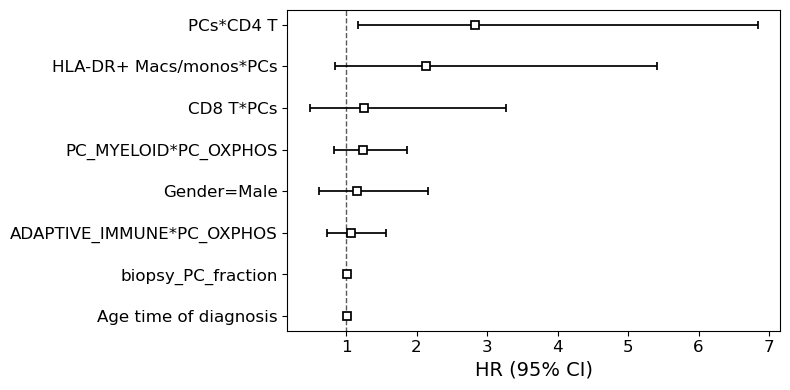

In [90]:
fig, ax = plt.subplots(figsize=(8, 4))
cph.plot(ax=ax, hazard_ratios=True)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_xlabel(ax.get_xlabel(), fontsize=14)
fig.tight_layout()
fig.savefig(os.path.join(save_path, f"coxph_pfs_all_scaled_biopsy_pc.{extension}"), bbox_inches='tight')

In [91]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 63 total observations, 11 right-censored observations>
             duration col = 'Days to progression (PFS)'
                event col = 'Event (Progress) occurred'
                penalizer = 0.01
                 l1 ratio = 0.5
      baseline estimation = breslow
   number of observations = 63
number of events observed = 52
   partial log-likelihood = -171.78
         time fit was run = 2025-06-11 09:03:13 UTC

---
                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                  
Gender=Male                0.15      1.16      0.32           -0.48            0.77                0.62                2.16
Age time of diagnosis      0.01      1.01      0.02           -0.03            0.05                0.97                1.05
PC_MYELOID*PC_OXPHOS       0.22      1.24      0.21           -0.19            0.62                0.83                1.86
PCs*CD4 T                  1.04      2.83      0.45            0.16            1.92                1.17                6.84
CD8 T*PCs                  0.23      1.26      0.49           -0.72            1.18                0.49                3.26
HLA-DR+ Macs/monos*PCs     0.76      2.14      0.47           -0.17            1.69                0.85                5.41
ADAPTIVE_IMMUNE*PC_OXPHOS  0.07      1.07      0.20           -0.32            0.45                0.73                1.57
biopsy_PC_fraction         0.02      1.02      0.01            0.00            0.03                1.00                1.03

                           cmp to    z    p  -log2(p)
covariate                                            
Gender=Male                  0.00 0.46 0.65      0.62
Age time of diagnosis        0.00 0.57 0.57      0.82
PC_MYELOID*PC_OXPHOS         0.00 1.05 0.29      1.78
PCs*CD4 T                    0.00 2.32 0.02      5.61
CD8 T*PCs                    0.00 0.48 0.63      0.66
HLA-DR+ Macs/monos*PCs       0.00 1.60 0.11      3.20
ADAPTIVE_IMMUNE*PC_OXPHOS    0.00 0.34 0.73      0.45
biopsy_PC_fraction           0.00 1.98 0.05      4.40
---
Concordance = 0.66
Partial AIC = 359.55
log-likelihood ratio test = 15.49 on 8 df
-log2(p) of ll-ratio test = 4.31

In [92]:
results = proportional_hazard_test(cph, md_pfs_numeric, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 63 total observations, 11 right-censored observations>
         test_name = proportional_hazard_test

---
                           test_statistic    p  -log2(p)
ADAPTIVE_IMMUNE*PC_OXPHOS            0.08 0.78      0.36
Age time of diagnosis                0.88 0.35      1.52
CD8 T*PCs                            2.13 0.14      2.80
Gender=Male                          0.40 0.53      0.92
HLA-DR+ Macs/monos*PCs               2.93 0.09      3.52
PC_MYELOID*PC_OXPHOS                 2.75 0.10      3.36
PCs*CD4 T                            0.65 0.42      1.26
biopsy_PC_fraction                   1.83 0.18      2.51

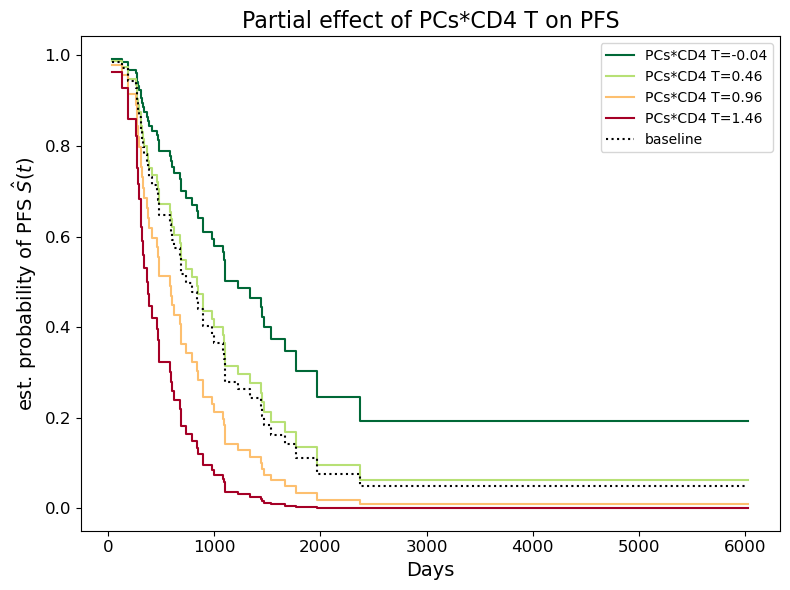

In [93]:
values= list(np.arange(-0.004, 0.16, 0.05)*10)
values = [round(v, 3) for v in values]
fig, ax = plt.subplots(figsize=(8, 6))
cph.plot_partial_effects_on_outcome('PCs*CD4 T', values= values, cmap='RdYlGn_r', ax=ax)
ax.set_title('Partial effect of PCs*CD4 T on PFS', fontsize=16)
ax.set_xlabel('Days', fontsize=14)
ax.set_ylabel(r"est. probability of PFS $\hat{S}(t)$", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(save_path, f"PCs*CD4 T_partial_effects_on_outcomes_scaled_pcfraction.{extension}"), bbox_inches='tight')

# CoxPH with only patient with ISS data

In [94]:
biopsy_pc_fraction = pd.read_excel('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/metadata/percent PCs in biopsies.xlsx')
biopsy_pc_fraction['IMC label'] = biopsy_pc_fraction['IMC label'].astype(str)
biopsy_pc_fraction['IMC label'] = ['IMC' + (x if len(x) >= 2 else '0' + x) for x in biopsy_pc_fraction['IMC label'] if x]
biopsy_pc_fraction.dropna(inplace=True)
md = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/metadata/metadata.csv')
md = md[md['Cohort'].isin(['B', 'UB'])]
md = md.dropna(subset=['Days to progression (PFS)']).reset_index(drop=True)
md['PC_MYELOID*PC_OXPHOS'] = md['IMC label'].map(nbh_enrichment['PC_MYELOID*PC_OXPHOS'])*10
md['PCs*CD4 T'] = md['IMC label'].map(nbh_enrichment2['PCs*CD4 T'])*10
md['CD8 T*PCs'] = md['IMC label'].map(nbh_enrichment2['CD8 T*PCs'])*10
md['HLA-DR+ Macs/monos*PCs'] = md['IMC label'].map(nbh_enrichment2['HLA-DR+ Macs/monos*PCs'])*10
md['ADAPTIVE_IMMUNE*PC_OXPHOS'] = md['IMC label'].map(nbh_enrichment['ADAPTIVE_IMMUNE*PC_OXPHOS'])*10
md['biopsy_PC_fraction'] = md['IMC label'].map(biopsy_pc_fraction.set_index('IMC label')['% PCs from biopsy'])
md_cox = md.drop(columns=['IMC label', 'Cohort', 'BMI', 'FISH/(translocations/del)','Treatment line 1', 'Days to progression from noBD/SMM to BD', 
                              'PFS from first time of diagnosis until relapse (days)', 'Short_long PFS (< or >  2 yrs)', 'Event (Death) occurred', 
                              'OS (days)', 'Fractures ossis  longi or ossis plani', '>= 1 lesion', '>=3 lesions', '>=5 lesions', '>=10 lesions', 'Bone disease later in disease course',
                              #'Gender', 'Age time of diagnosis', 
                              'Compression fractures ',
                              'Bone disease upon time of diagnosis/biopsy',
                              ])
md_cox.head()


,Gender,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),R-ISS,PC_MYELOID*PC_OXPHOS,PCs*CD4 T,CD8 T*PCs,HLA-DR+ Macs/monos*PCs,ADAPTIVE_IMMUNE*PC_OXPHOS,biopsy_PC_fraction
0,Male,67.0,True,1766.0,II,0.573700,0.421207,0.259899,0.369306,0.603781,10.0
1,Male,66.0,True,1448.0,II,1.586357,0.184823,-0.712576,-0.028371,-0.874054,95.0
2,Female,65.0,True,833.0,II,1.753984,0.888849,-0.222941,-0.412395,-0.597045,55.0
3,Male,58.0,True,1337.0,NaN,0.198029,0.511363,0.328676,0.264025,0.169969,10.0
4,Female,79.0,True,258.0,NaN,1.045386,0.891683,0.066120,0.361441,0.507116,65.0


In [95]:
md_cox['R-ISS'].value_counts()

R-ISS
II     28
I      16
III     6
Name: count, dtype: int64

In [96]:
md_pfs = md_cox.dropna().reset_index(drop=True)
arr_3 = np.array(md_pfs['Days to progression (PFS)'])
arr_pfs_numeric = np.empty(len(arr_3), dtype=[('Status', '?'), ('PFS_in_days', '<f8')])
for i, e in enumerate(arr_3):
    if md_pfs['Event (Progress) occurred'][i] == False:
        arr_pfs_numeric[i] = (False, e)
    else:
        arr_pfs_numeric[i] = (True, e)
cat_cols = md_pfs.select_dtypes(include=['object']).columns
md_pfs[cat_cols] = md_pfs[cat_cols].astype('category')
md_pfs_numeric = OneHotEncoder().fit_transform(md_pfs)
md_pfs_numeric

,Gender=Male,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),R-ISS=II,R-ISS=III,PC_MYELOID*PC_OXPHOS,PCs*CD4 T,CD8 T*PCs,HLA-DR+ Macs/monos*PCs,ADAPTIVE_IMMUNE*PC_OXPHOS,biopsy_PC_fraction
0,1.0,67.0,True,1766.0,1.0,0.0,0.573700,0.421207,0.259899,0.369306,0.603781,10.0
1,1.0,66.0,True,1448.0,1.0,0.0,1.586357,0.184823,-0.712576,-0.028371,-0.874054,95.0
2,0.0,65.0,True,833.0,1.0,0.0,1.753984,0.888849,-0.222941,-0.412395,-0.597045,55.0
3,0.0,69.0,True,1443.0,1.0,0.0,0.539156,0.164200,0.405154,0.175277,0.030152,50.0
4,0.0,66.0,True,185.0,0.0,1.0,-0.024280,1.032474,-0.561173,0.047465,-1.655832,60.0
5,1.0,61.0,True,894.0,1.0,0.0,-2.701047,0.424011,-0.628295,0.241096,-1.359114,90.0
6,1.0,62.0,True,1669.0,0.0,0.0,0.352245,0.189095,0.626468,0.729200,0.340575,30.0
7,1.0,72.0,True,269.0,1.0,0.0,0.686257,0.496717,0.559871,0.871516,-0.182591,20.0
8,1.0,61.0,True,843.0,1.0,0.0,0.370075,0.289529,0.194650,0.369797,0.386837,10.0
9,1.0,60.0,True,188.0,1.0,0.0,0.871427,1.461971,0.526823,1.160034,0.383995,50.0


In [97]:
cph = CoxPHFitter(penalizer=0.01, l1_ratio=0.5)
cph.fit(md_pfs_numeric, duration_col = 'Days to progression (PFS)', event_col = 'Event (Progress) occurred')

<lifelines.CoxPHFitter: fitted with 50 total observations, 10 right-censored observations>

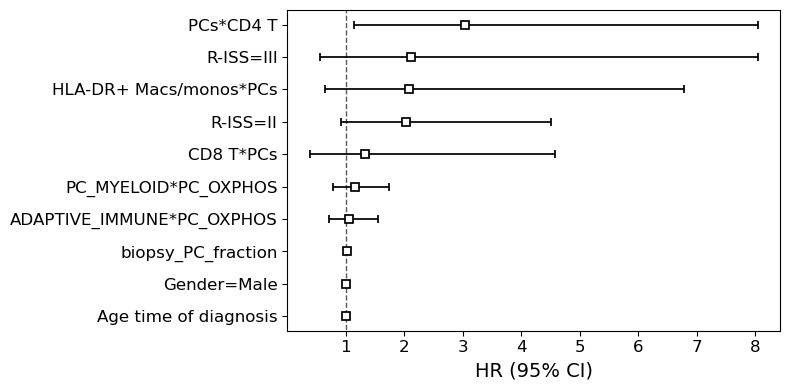

In [98]:
fig, ax = plt.subplots(figsize=(8, 4))
cph.plot(ax=ax, hazard_ratios=True)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_xlabel(ax.get_xlabel(), fontsize=14)
fig.tight_layout()
fig.savefig(os.path.join(save_path, f"coxph_pfs_all_scaled_biopsy_pc_riss.{extension}"), bbox_inches='tight')

In [99]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 50 total observations, 10 right-censored observations>
             duration col = 'Days to progression (PFS)'
                event col = 'Event (Progress) occurred'
                penalizer = 0.01
                 l1 ratio = 0.5
      baseline estimation = breslow
   number of observations = 50
number of events observed = 40
   partial log-likelihood = -122.70
         time fit was run = 2025-06-11 09:03:13 UTC

---
                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                  
Gender=Male                0.00      1.00      0.03           -0.05            0.05                0.95                1.05
Age time of diagnosis     -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
R-ISS=II                   0.71      2.03      0.41           -0.09            1.51                0.91                4.51
R-ISS=III                  0.75      2.12      0.68           -0.58            2.08                0.56                8.04
PC_MYELOID*PC_OXPHOS       0.15      1.16      0.21           -0.26            0.55                0.77                1.73
PCs*CD4 T                  1.11      3.03      0.50            0.13            2.08                1.14                8.04
CD8 T*PCs                  0.28      1.33      0.63           -0.96            1.52                0.38                4.57
HLA-DR+ Macs/monos*PCs     0.74      2.09      0.60           -0.44            1.91                0.64                6.78
ADAPTIVE_IMMUNE*PC_OXPHOS  0.05      1.05      0.20           -0.33            0.44                0.72                1.55
biopsy_PC_fraction         0.02      1.02      0.01           -0.00            0.04                1.00                1.04

                           cmp to     z    p  -log2(p)
covariate                                             
Gender=Male                  0.00  0.00 1.00      0.00
Age time of diagnosis        0.00 -0.00 1.00      0.00
R-ISS=II                     0.00  1.73 0.08      3.57
R-ISS=III                    0.00  1.11 0.27      1.90
PC_MYELOID*PC_OXPHOS         0.00  0.70 0.48      1.05
PCs*CD4 T                    0.00  2.23 0.03      5.27
CD8 T*PCs                    0.00  0.45 0.65      0.61
HLA-DR+ Macs/monos*PCs       0.00  1.23 0.22      2.18
ADAPTIVE_IMMUNE*PC_OXPHOS    0.00  0.27 0.79      0.35
biopsy_PC_fraction           0.00  1.70 0.09      3.49
---
Concordance = 0.69
Partial AIC = 265.39
log-likelihood ratio test = 17.70 on 10 df
-log2(p) of ll-ratio test = 4.05

In [100]:
md_pfs = md_cox.dropna().reset_index(drop=True)
arr_3 = np.array(md_pfs['Days to progression (PFS)'])
arr_pfs_numeric = np.empty(len(arr_3), dtype=[('Status', '?'), ('PFS_in_days', '<f8')])
for i, e in enumerate(arr_3):
    if md_pfs['Event (Progress) occurred'][i] == False:
        arr_pfs_numeric[i] = (False, e)
    else:
        arr_pfs_numeric[i] = (True, e)
cat_cols = md_pfs.select_dtypes(include=['object']).columns
md_pfs[cat_cols] = md_pfs[cat_cols].astype('category')
md_pfs_numeric = OneHotEncoder().fit_transform(md_pfs)
md_pfs_numeric['R-ISS=I'] = np.where(md_pfs['R-ISS'] == 'I', 1.0, 0)
md_pfs_numeric.drop(columns=['R-ISS=III'], inplace=True)
md_pfs_numeric

,Gender=Male,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),R-ISS=II,PC_MYELOID*PC_OXPHOS,PCs*CD4 T,CD8 T*PCs,HLA-DR+ Macs/monos*PCs,ADAPTIVE_IMMUNE*PC_OXPHOS,biopsy_PC_fraction,R-ISS=I
0,1.0,67.0,True,1766.0,1.0,0.573700,0.421207,0.259899,0.369306,0.603781,10.0,0.0
1,1.0,66.0,True,1448.0,1.0,1.586357,0.184823,-0.712576,-0.028371,-0.874054,95.0,0.0
2,0.0,65.0,True,833.0,1.0,1.753984,0.888849,-0.222941,-0.412395,-0.597045,55.0,0.0
3,0.0,69.0,True,1443.0,1.0,0.539156,0.164200,0.405154,0.175277,0.030152,50.0,0.0
4,0.0,66.0,True,185.0,0.0,-0.024280,1.032474,-0.561173,0.047465,-1.655832,60.0,0.0
5,1.0,61.0,True,894.0,1.0,-2.701047,0.424011,-0.628295,0.241096,-1.359114,90.0,0.0
6,1.0,62.0,True,1669.0,0.0,0.352245,0.189095,0.626468,0.729200,0.340575,30.0,1.0
7,1.0,72.0,True,269.0,1.0,0.686257,0.496717,0.559871,0.871516,-0.182591,20.0,0.0
8,1.0,61.0,True,843.0,1.0,0.370075,0.289529,0.194650,0.369797,0.386837,10.0,0.0
9,1.0,60.0,True,188.0,1.0,0.871427,1.461971,0.526823,1.160034,0.383995,50.0,0.0


In [101]:
cph = CoxPHFitter(penalizer=0.01, l1_ratio=0.5)
cph.fit(md_pfs_numeric, duration_col = 'Days to progression (PFS)', event_col = 'Event (Progress) occurred')

<lifelines.CoxPHFitter: fitted with 50 total observations, 10 right-censored observations>

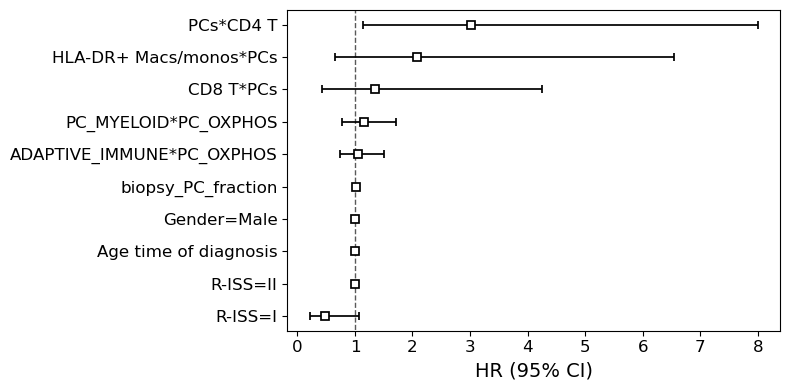

In [102]:
fig, ax = plt.subplots(figsize=(8, 4))
cph.plot(ax=ax, hazard_ratios=True)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_xlabel(ax.get_xlabel(), fontsize=14)
fig.tight_layout()
fig.savefig(os.path.join(save_path, f"coxph_pfs_all_scaled_biopsy_pc_riss_2.{extension}"), bbox_inches='tight')

In [103]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 50 total observations, 10 right-censored observations>
             duration col = 'Days to progression (PFS)'
                event col = 'Event (Progress) occurred'
                penalizer = 0.01
                 l1 ratio = 0.5
      baseline estimation = breslow
   number of observations = 50
number of events observed = 40
   partial log-likelihood = -122.63
         time fit was run = 2025-06-11 09:03:14 UTC

---
                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                  
Gender=Male                0.00      1.00      0.02           -0.03            0.03                0.97                1.03
Age time of diagnosis     -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
R-ISS=II                  -0.00      1.00      0.02           -0.04            0.04                0.96                1.04
PC_MYELOID*PC_OXPHOS       0.14      1.15      0.20           -0.26            0.54                0.77                1.71
PCs*CD4 T                  1.11      3.02      0.50            0.13            2.08                1.14                8.00
CD8 T*PCs                  0.30      1.35      0.59           -0.85            1.45                0.43                4.26
HLA-DR+ Macs/monos*PCs     0.73      2.08      0.59           -0.42            1.88                0.66                6.55
ADAPTIVE_IMMUNE*PC_OXPHOS  0.06      1.06      0.18           -0.29            0.41                0.75                1.50
biopsy_PC_fraction         0.02      1.02      0.01           -0.00            0.04                1.00                1.04
R-ISS=I                   -0.73      0.48      0.41           -1.53            0.08                0.22                1.08

                           cmp to     z    p  -log2(p)
covariate                                             
Gender=Male                  0.00  0.00 1.00      0.00
Age time of diagnosis        0.00 -0.00 1.00      0.00
R-ISS=II                     0.00 -0.00 1.00      0.00
PC_MYELOID*PC_OXPHOS         0.00  0.70 0.48      1.05
PCs*CD4 T                    0.00  2.23 0.03      5.27
CD8 T*PCs                    0.00  0.51 0.61      0.71
HLA-DR+ Macs/monos*PCs       0.00  1.25 0.21      2.23
ADAPTIVE_IMMUNE*PC_OXPHOS    0.00  0.32 0.75      0.42
biopsy_PC_fraction           0.00  1.93 0.05      4.23
R-ISS=I                      0.00 -1.78 0.08      3.72
---
Concordance = 0.68
Partial AIC = 265.25
log-likelihood ratio test = 17.84 on 10 df
-log2(p) of ll-ratio test = 4.11

# With R-ISS including NAs as category

In [104]:
biopsy_pc_fraction = pd.read_excel('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/metadata/percent PCs in biopsies.xlsx')
biopsy_pc_fraction['IMC label'] = biopsy_pc_fraction['IMC label'].astype(str)
biopsy_pc_fraction['IMC label'] = ['IMC' + (x if len(x) >= 2 else '0' + x) for x in biopsy_pc_fraction['IMC label'] if x]
biopsy_pc_fraction.dropna(inplace=True)
md = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/metadata/metadata.csv')
md = md[md['Cohort'].isin(['B', 'UB'])]
md = md.dropna(subset=['Days to progression (PFS)']).reset_index(drop=True)
md['PC_MYELOID*PC_OXPHOS'] = md['IMC label'].map(nbh_enrichment['PC_MYELOID*PC_OXPHOS'])*10
md['PCs*CD4 T'] = md['IMC label'].map(nbh_enrichment2['PCs*CD4 T'])*10
md['CD8 T*PCs'] = md['IMC label'].map(nbh_enrichment2['CD8 T*PCs'])*10
md['HLA-DR+ Macs/monos*PCs'] = md['IMC label'].map(nbh_enrichment2['HLA-DR+ Macs/monos*PCs'])*10
md['ADAPTIVE_IMMUNE*PC_OXPHOS'] = md['IMC label'].map(nbh_enrichment['ADAPTIVE_IMMUNE*PC_OXPHOS'])*10
md['biopsy_PC_fraction'] = md['IMC label'].map(biopsy_pc_fraction.set_index('IMC label')['% PCs from biopsy'])
md_cox = md.drop(columns=['IMC label', 'Cohort', 'BMI', 'FISH/(translocations/del)','Treatment line 1', 'Days to progression from noBD/SMM to BD', 
                              'PFS from first time of diagnosis until relapse (days)', 'Short_long PFS (< or >  2 yrs)', 'Event (Death) occurred', 
                              'OS (days)', 'Fractures ossis  longi or ossis plani', '>= 1 lesion', '>=3 lesions', '>=5 lesions', '>=10 lesions', 'Bone disease later in disease course',
                              #'Gender', 'Age time of diagnosis', 
                              'Compression fractures ',
                              'Bone disease upon time of diagnosis/biopsy',
                              ])
md_cox.head()


,Gender,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),R-ISS,PC_MYELOID*PC_OXPHOS,PCs*CD4 T,CD8 T*PCs,HLA-DR+ Macs/monos*PCs,ADAPTIVE_IMMUNE*PC_OXPHOS,biopsy_PC_fraction
0,Male,67.0,True,1766.0,II,0.573700,0.421207,0.259899,0.369306,0.603781,10.0
1,Male,66.0,True,1448.0,II,1.586357,0.184823,-0.712576,-0.028371,-0.874054,95.0
2,Female,65.0,True,833.0,II,1.753984,0.888849,-0.222941,-0.412395,-0.597045,55.0
3,Male,58.0,True,1337.0,NaN,0.198029,0.511363,0.328676,0.264025,0.169969,10.0
4,Female,79.0,True,258.0,NaN,1.045386,0.891683,0.066120,0.361441,0.507116,65.0


In [105]:
md_cox['R-ISS'].value_counts()

R-ISS
II     28
I      16
III     6
Name: count, dtype: int64

In [106]:
md_cox['R-ISS'] = md_cox['R-ISS'].astype(str)
md_cox['R-ISS'] = md_cox['R-ISS'].fillna('NA')
md_pfs = md_cox.dropna().reset_index(drop=True)
arr_3 = np.array(md_pfs['Days to progression (PFS)'])
arr_pfs_numeric = np.empty(len(arr_3), dtype=[('Status', '?'), ('PFS_in_days', '<f8')])
for i, e in enumerate(arr_3):
    if md_pfs['Event (Progress) occurred'][i] == False:
        arr_pfs_numeric[i] = (False, e)
    else:
        arr_pfs_numeric[i] = (True, e)
cat_cols = md_pfs.select_dtypes(include=['object']).columns
md_pfs[cat_cols] = md_pfs[cat_cols].astype('category')
md_pfs_numeric = OneHotEncoder().fit_transform(md_pfs)
#md_pfs_numeric['R-ISS=I'] = np.where(md_pfs['R-ISS'] == 'I', 1.0, 0)
#md_pfs_numeric.drop(columns=['R-ISS=III'], inplace=True)
md_pfs_numeric

,Gender=Male,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),R-ISS=II,R-ISS=III,R-ISS=nan,PC_MYELOID*PC_OXPHOS,PCs*CD4 T,CD8 T*PCs,HLA-DR+ Macs/monos*PCs,ADAPTIVE_IMMUNE*PC_OXPHOS,biopsy_PC_fraction
0,1.0,67.0,True,1766.0,1.0,0.0,0.0,0.573700,0.421207,0.259899,0.369306,0.603781,10.0
1,1.0,66.0,True,1448.0,1.0,0.0,0.0,1.586357,0.184823,-0.712576,-0.028371,-0.874054,95.0
2,0.0,65.0,True,833.0,1.0,0.0,0.0,1.753984,0.888849,-0.222941,-0.412395,-0.597045,55.0
3,1.0,58.0,True,1337.0,0.0,0.0,1.0,0.198029,0.511363,0.328676,0.264025,0.169969,10.0
4,0.0,79.0,True,258.0,0.0,0.0,1.0,1.045386,0.891683,0.066120,0.361441,0.507116,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.0,58.0,True,1536.0,1.0,0.0,0.0,0.188512,0.897453,0.017767,0.235693,-0.328402,45.0
59,0.0,54.0,False,6033.0,0.0,0.0,0.0,0.591141,0.478542,0.472081,0.751342,0.116658,9.9
60,0.0,71.0,True,2375.0,0.0,0.0,1.0,0.677594,0.511499,0.183141,0.370500,0.323863,50.0
61,0.0,58.0,True,1966.0,0.0,0.0,1.0,0.544465,-0.000592,0.247649,0.041851,0.068558,8.0


In [107]:
cph = CoxPHFitter(penalizer=0.01, l1_ratio=0.5)
cph.fit(md_pfs_numeric, duration_col = 'Days to progression (PFS)', event_col = 'Event (Progress) occurred')

<lifelines.CoxPHFitter: fitted with 63 total observations, 11 right-censored observations>

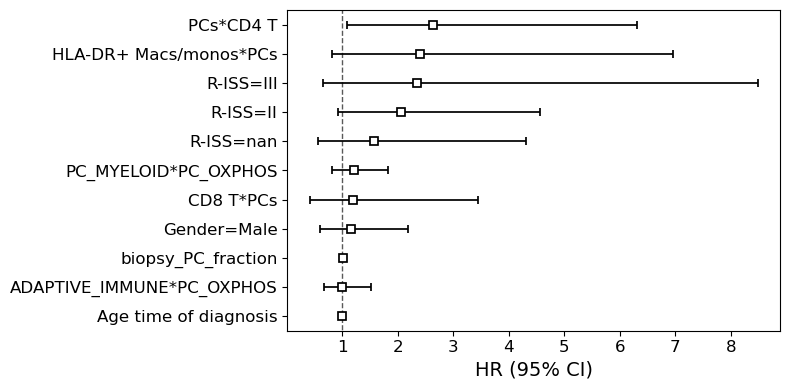

In [108]:
fig, ax = plt.subplots(figsize=(8, 4))
cph.plot(ax=ax, hazard_ratios=True)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_xlabel(ax.get_xlabel(), fontsize=14)
fig.tight_layout()
fig.savefig(os.path.join(save_path, f"coxph_pfs_all_scaled_biopsy_pc_riss_3.{extension}"), bbox_inches='tight')

In [109]:
biopsy_pc_fraction = pd.read_excel('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/metadata/percent PCs in biopsies.xlsx')
biopsy_pc_fraction['IMC label'] = biopsy_pc_fraction['IMC label'].astype(str)
biopsy_pc_fraction['IMC label'] = ['IMC' + (x if len(x) >= 2 else '0' + x) for x in biopsy_pc_fraction['IMC label'] if x]
biopsy_pc_fraction.dropna(inplace=True)
md = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/metadata/metadata.csv')
md = md[md['Cohort'].isin(['B', 'UB'])]
md = md.dropna(subset=['Days to progression (PFS)']).reset_index(drop=True)
md['PC_MYELOID*PC_OXPHOS'] = md['IMC label'].map(nbh_enrichment['PC_MYELOID*PC_OXPHOS'])*10
md['PCs*CD4 T'] = md['IMC label'].map(nbh_enrichment2['PCs*CD4 T'])*10
md['CD8 T*PCs'] = md['IMC label'].map(nbh_enrichment2['CD8 T*PCs'])*10
md['HLA-DR+ Macs/monos*PCs'] = md['IMC label'].map(nbh_enrichment2['HLA-DR+ Macs/monos*PCs'])*10
md['ADAPTIVE_IMMUNE*PC_OXPHOS'] = md['IMC label'].map(nbh_enrichment['ADAPTIVE_IMMUNE*PC_OXPHOS'])*10
md['biopsy_PC_fraction'] = md['IMC label'].map(biopsy_pc_fraction.set_index('IMC label')['% PCs from biopsy'])
md_cox = md.drop(columns=['IMC label', 'Cohort', 'BMI', 'FISH/(translocations/del)','Treatment line 1', 'Days to progression from noBD/SMM to BD', 
                              'PFS from first time of diagnosis until relapse (days)', 'Short_long PFS (< or >  2 yrs)', 'Event (Death) occurred', 
                              'OS (days)', 'Fractures ossis  longi or ossis plani', '>= 1 lesion', '>=3 lesions', '>=5 lesions', '>=10 lesions', 'Bone disease later in disease course',
                              #'Gender', 'Age time of diagnosis', 
                              'Compression fractures ',
                              'Bone disease upon time of diagnosis/biopsy',
                              ])

md_cox['R-ISS'] = md_cox['R-ISS'].astype(str)
md_cox['R-ISS'] = md_cox['R-ISS'].fillna('NA')
md_pfs = md_cox.dropna().reset_index(drop=True)
arr_3 = np.array(md_pfs['Days to progression (PFS)'])
arr_pfs_numeric = np.empty(len(arr_3), dtype=[('Status', '?'), ('PFS_in_days', '<f8')])
for i, e in enumerate(arr_3):
    if md_pfs['Event (Progress) occurred'][i] == False:
        arr_pfs_numeric[i] = (False, e)
    else:
        arr_pfs_numeric[i] = (True, e)
cat_cols = md_pfs.select_dtypes(include=['object']).columns
md_pfs[cat_cols] = md_pfs[cat_cols].astype('category')
md_pfs_numeric = OneHotEncoder().fit_transform(md_pfs)
md_pfs_numeric['R-ISS=I'] = np.where(md_pfs['R-ISS'] == 'I', 1.0, 0)
md_pfs_numeric.drop(columns=['R-ISS=nan'], inplace=True)
md_pfs_numeric

,Gender=Male,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),R-ISS=II,R-ISS=III,PC_MYELOID*PC_OXPHOS,PCs*CD4 T,CD8 T*PCs,HLA-DR+ Macs/monos*PCs,ADAPTIVE_IMMUNE*PC_OXPHOS,biopsy_PC_fraction,R-ISS=I
0,1.0,67.0,True,1766.0,1.0,0.0,0.573700,0.421207,0.259899,0.369306,0.603781,10.0,0.0
1,1.0,66.0,True,1448.0,1.0,0.0,1.586357,0.184823,-0.712576,-0.028371,-0.874054,95.0,0.0
2,0.0,65.0,True,833.0,1.0,0.0,1.753984,0.888849,-0.222941,-0.412395,-0.597045,55.0,0.0
3,1.0,58.0,True,1337.0,0.0,0.0,0.198029,0.511363,0.328676,0.264025,0.169969,10.0,0.0
4,0.0,79.0,True,258.0,0.0,0.0,1.045386,0.891683,0.066120,0.361441,0.507116,65.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.0,58.0,True,1536.0,1.0,0.0,0.188512,0.897453,0.017767,0.235693,-0.328402,45.0,0.0
59,0.0,54.0,False,6033.0,0.0,0.0,0.591141,0.478542,0.472081,0.751342,0.116658,9.9,1.0
60,0.0,71.0,True,2375.0,0.0,0.0,0.677594,0.511499,0.183141,0.370500,0.323863,50.0,0.0
61,0.0,58.0,True,1966.0,0.0,0.0,0.544465,-0.000592,0.247649,0.041851,0.068558,8.0,0.0


In [110]:
cph = CoxPHFitter(penalizer=0.01, l1_ratio=0.5)
cph.fit(md_pfs_numeric, duration_col = 'Days to progression (PFS)', event_col = 'Event (Progress) occurred')

<lifelines.CoxPHFitter: fitted with 63 total observations, 11 right-censored observations>

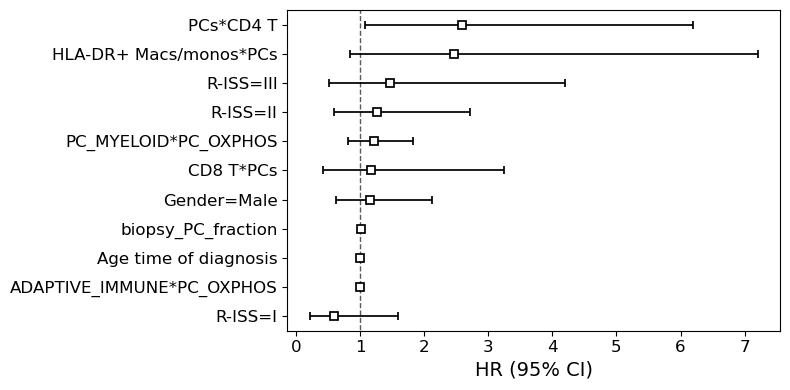

In [111]:
fig, ax = plt.subplots(figsize=(8, 4))
cph.plot(ax=ax, hazard_ratios=True)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_xlabel(ax.get_xlabel(), fontsize=14)
fig.tight_layout()
fig.savefig(os.path.join(save_path, f"coxph_pfs_all_scaled_biopsy_pc_riss_4.{extension}"), bbox_inches='tight')

# Combining R-ISS II/III

In [112]:
biopsy_pc_fraction = pd.read_excel('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/metadata/percent PCs in biopsies.xlsx')
biopsy_pc_fraction['IMC label'] = biopsy_pc_fraction['IMC label'].astype(str)
biopsy_pc_fraction['IMC label'] = ['IMC' + (x if len(x) >= 2 else '0' + x) for x in biopsy_pc_fraction['IMC label'] if x]
biopsy_pc_fraction.dropna(inplace=True)
md = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/metadata/metadata.csv')
md = md[md['Cohort'].isin(['B', 'UB'])]
md = md.dropna(subset=['Days to progression (PFS)']).reset_index(drop=True)
md['PC_MYELOID*PC_OXPHOS'] = md['IMC label'].map(nbh_enrichment['PC_MYELOID*PC_OXPHOS'])*10
md['PCs*CD4 T'] = md['IMC label'].map(nbh_enrichment2['PCs*CD4 T'])*10
md['CD8 T*PCs'] = md['IMC label'].map(nbh_enrichment2['CD8 T*PCs'])*10
md['HLA-DR+ Macs/monos*PCs'] = md['IMC label'].map(nbh_enrichment2['HLA-DR+ Macs/monos*PCs'])*10
md['ADAPTIVE_IMMUNE*PC_OXPHOS'] = md['IMC label'].map(nbh_enrichment['ADAPTIVE_IMMUNE*PC_OXPHOS'])*10
md['biopsy_PC_fraction'] = md['IMC label'].map(biopsy_pc_fraction.set_index('IMC label')['% PCs from biopsy'])
md_cox = md.drop(columns=['IMC label', 'Cohort', 'BMI', 'FISH/(translocations/del)','Treatment line 1', 'Days to progression from noBD/SMM to BD', 
                              'PFS from first time of diagnosis until relapse (days)', 'Short_long PFS (< or >  2 yrs)', 'Event (Death) occurred', 
                              'OS (days)', 'Fractures ossis  longi or ossis plani', '>= 1 lesion', '>=3 lesions', '>=5 lesions', '>=10 lesions', 'Bone disease later in disease course',
                              #'Gender', 'Age time of diagnosis', 
                              'Compression fractures ',
                              'Bone disease upon time of diagnosis/biopsy',
                              ])
md_cox.head()


,Gender,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),R-ISS,PC_MYELOID*PC_OXPHOS,PCs*CD4 T,CD8 T*PCs,HLA-DR+ Macs/monos*PCs,ADAPTIVE_IMMUNE*PC_OXPHOS,biopsy_PC_fraction
0,Male,67.0,True,1766.0,II,0.573700,0.421207,0.259899,0.369306,0.603781,10.0
1,Male,66.0,True,1448.0,II,1.586357,0.184823,-0.712576,-0.028371,-0.874054,95.0
2,Female,65.0,True,833.0,II,1.753984,0.888849,-0.222941,-0.412395,-0.597045,55.0
3,Male,58.0,True,1337.0,NaN,0.198029,0.511363,0.328676,0.264025,0.169969,10.0
4,Female,79.0,True,258.0,NaN,1.045386,0.891683,0.066120,0.361441,0.507116,65.0


In [113]:
md_cox['R-ISS'] = md_cox['R-ISS'].replace({'II': 'II/III', 'III': 'II/III'})

In [114]:
md_pfs = md_cox.dropna().reset_index(drop=True)
arr_3 = np.array(md_pfs['Days to progression (PFS)'])
arr_pfs_numeric = np.empty(len(arr_3), dtype=[('Status', '?'), ('PFS_in_days', '<f8')])
for i, e in enumerate(arr_3):
    if md_pfs['Event (Progress) occurred'][i] == False:
        arr_pfs_numeric[i] = (False, e)
    else:
        arr_pfs_numeric[i] = (True, e)
cat_cols = md_pfs.select_dtypes(include=['object']).columns
md_pfs[cat_cols] = md_pfs[cat_cols].astype('category')
md_pfs_numeric = OneHotEncoder().fit_transform(md_pfs)
md_pfs_numeric

,Gender=Male,Age time of diagnosis,Event (Progress) occurred,Days to progression (PFS),R-ISS=II/III,PC_MYELOID*PC_OXPHOS,PCs*CD4 T,CD8 T*PCs,HLA-DR+ Macs/monos*PCs,ADAPTIVE_IMMUNE*PC_OXPHOS,biopsy_PC_fraction
0,1.0,67.0,True,1766.0,1.0,0.573700,0.421207,0.259899,0.369306,0.603781,10.0
1,1.0,66.0,True,1448.0,1.0,1.586357,0.184823,-0.712576,-0.028371,-0.874054,95.0
2,0.0,65.0,True,833.0,1.0,1.753984,0.888849,-0.222941,-0.412395,-0.597045,55.0
3,0.0,69.0,True,1443.0,1.0,0.539156,0.164200,0.405154,0.175277,0.030152,50.0
4,0.0,66.0,True,185.0,1.0,-0.024280,1.032474,-0.561173,0.047465,-1.655832,60.0
5,1.0,61.0,True,894.0,1.0,-2.701047,0.424011,-0.628295,0.241096,-1.359114,90.0
6,1.0,62.0,True,1669.0,0.0,0.352245,0.189095,0.626468,0.729200,0.340575,30.0
7,1.0,72.0,True,269.0,1.0,0.686257,0.496717,0.559871,0.871516,-0.182591,20.0
8,1.0,61.0,True,843.0,1.0,0.370075,0.289529,0.194650,0.369797,0.386837,10.0
9,1.0,60.0,True,188.0,1.0,0.871427,1.461971,0.526823,1.160034,0.383995,50.0


In [115]:
cph = CoxPHFitter(penalizer=0.01, l1_ratio=0.5)
cph.fit(md_pfs_numeric, duration_col = 'Days to progression (PFS)', event_col = 'Event (Progress) occurred')

<lifelines.CoxPHFitter: fitted with 50 total observations, 10 right-censored observations>

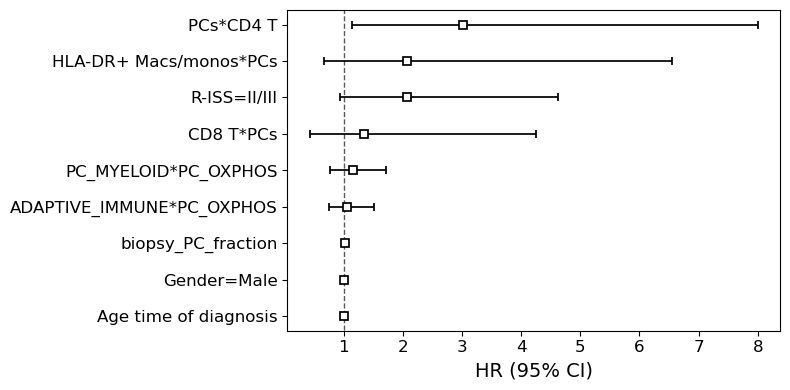

In [116]:
fig, ax = plt.subplots(figsize=(8, 4))
cph.plot(ax=ax, hazard_ratios=True)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_xlabel(ax.get_xlabel(), fontsize=14)
fig.tight_layout()
fig.savefig(os.path.join(save_path, f"coxph_pfs_all_scaled_biopsy_pc_riss_combined.{extension}"), bbox_inches='tight')

In [117]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 50 total observations, 10 right-censored observations>
             duration col = 'Days to progression (PFS)'
                event col = 'Event (Progress) occurred'
                penalizer = 0.01
                 l1 ratio = 0.5
      baseline estimation = breslow
   number of observations = 50
number of events observed = 40
   partial log-likelihood = -122.63
         time fit was run = 2025-06-11 09:03:14 UTC

---
                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                  
Gender=Male                0.00      1.00      0.02           -0.04            0.04                0.96                1.04
Age time of diagnosis     -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
R-ISS=II/III               0.73      2.07      0.41           -0.07            1.53                0.93                4.62
PC_MYELOID*PC_OXPHOS       0.14      1.15      0.20           -0.26            0.54                0.77                1.71
PCs*CD4 T                  1.11      3.02      0.50            0.13            2.08                1.14                8.00
CD8 T*PCs                  0.30      1.35      0.59           -0.85            1.45                0.43                4.26
HLA-DR+ Macs/monos*PCs     0.73      2.08      0.59           -0.42            1.88                0.66                6.55
ADAPTIVE_IMMUNE*PC_OXPHOS  0.06      1.06      0.18           -0.29            0.41                0.75                1.50
biopsy_PC_fraction         0.02      1.02      0.01           -0.00            0.04                1.00                1.04

                           cmp to     z    p  -log2(p)
covariate                                             
Gender=Male                  0.00  0.00 1.00      0.00
Age time of diagnosis        0.00 -0.00 1.00      0.00
R-ISS=II/III                 0.00  1.78 0.08      3.73
PC_MYELOID*PC_OXPHOS         0.00  0.70 0.48      1.05
PCs*CD4 T                    0.00  2.23 0.03      5.27
CD8 T*PCs                    0.00  0.51 0.61      0.71
HLA-DR+ Macs/monos*PCs       0.00  1.25 0.21      2.23
ADAPTIVE_IMMUNE*PC_OXPHOS    0.00  0.32 0.75      0.42
biopsy_PC_fraction           0.00  1.93 0.05      4.23
---
Concordance = 0.68
Partial AIC = 263.25
log-likelihood ratio test = 17.84 on 9 df
-log2(p) of ll-ratio test = 4.75

In [118]:
proportional_hazard_test(cph, md_pfs_numeric, time_transform='rank').print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 50 total observations, 10 right-censored observations>
         test_name = proportional_hazard_test

---
                           test_statistic    p  -log2(p)
ADAPTIVE_IMMUNE*PC_OXPHOS            0.02 0.90      0.16
Age time of diagnosis                0.01 0.93      0.10
CD8 T*PCs                            0.25 0.61      0.70
Gender=Male                          0.00 1.00      0.00
HLA-DR+ Macs/monos*PCs               0.11 0.74      0.44
PC_MYELOID*PC_OXPHOS                 1.28 0.26      1.95
PCs*CD4 T                            0.01 0.91      0.14
R-ISS=II/III                         0.19 0.66      0.60
biopsy_PC_fraction                   0.88 0.35      1.52